
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_2631839/1755373187.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


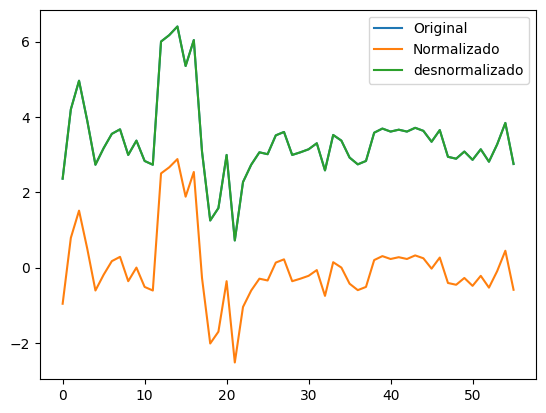

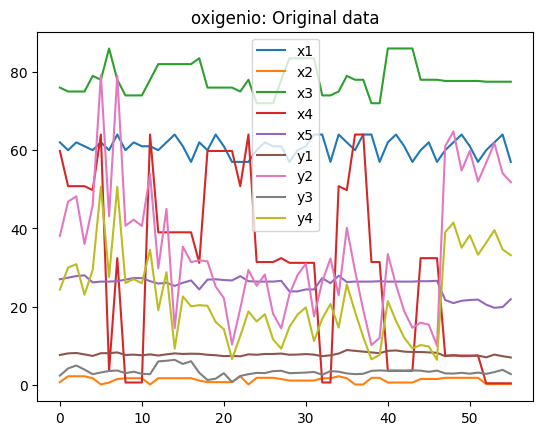

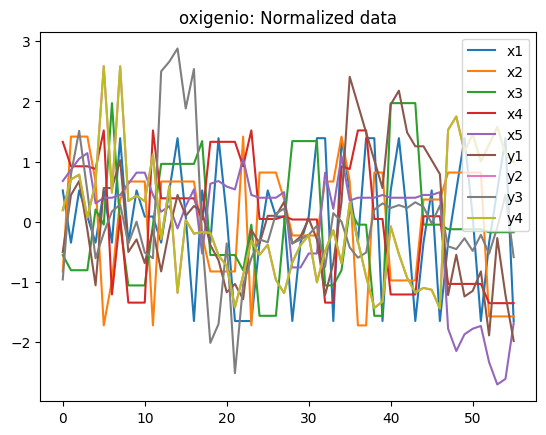

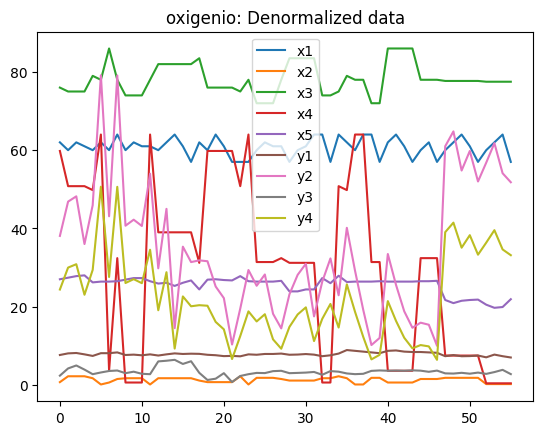

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y3"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y3")
test_out_scaler()
show_norm(label="oxigenio")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-05 00:50:15.331991: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 00:50:15.362479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 00:50:15.362508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 00:50:15.363556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 00:50:15.369604: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 00:50:15.370538: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  2.0442228709998744
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.31042794800032425
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.6205423060000612
Stopped at epoch:  7
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 65ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.6185917360007807
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.4794220789999599
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.3635970389996146
Stopped at epoch:  6
1/1 [==============================] - 0s 52ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Elapsed time:  0.5078327009996428
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Elapsed time:  0.42905444799998804
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 9 ++++++++++++++++++
Elapsed time:  0.4392732149999574
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 10 ++++++++++++++++++
Elapsed time:  0.

2024-04-05 00:52:22.422508: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_9] | 18 ++++++++++++++++++
Elapsed time:  0.043714354999792704
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_9] | 19 ++++++++++++++++++
Elapsed time:  0.04064505000042118
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 20 ++++++++++++++++++
Elapsed time:  0.0418144579998625
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_9] | 21 ++++++++++++++++++
Elapsed time:  0.035678266000104486
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_9] | 22 ++++++++++++++++++
Elapsed time:  0.03734726499988028
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_9] | 23 ++++++++++++++++++
Elapsed time:  0.056152387999645725
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_9] | 24 ++++++++++++++++++
Elap

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_9_0,0.837855,0.667796,0.723036,0.713338,0.179447,0.243585,0.354126,0.295604
model_2_9_1,0.847401,0.654307,0.739789,0.718035,0.168883,0.253476,0.332705,0.290760
model_2_9_2,0.852649,0.635620,0.763937,0.725090,0.163074,0.267177,0.301831,0.283485
model_2_9_3,0.885215,0.634583,0.770159,0.728330,0.127034,0.267938,0.293875,0.280144
model_2_9_4,0.896117,0.644435,0.772423,0.733361,0.114968,0.260714,0.290980,0.274957
model_2_9_5,0.900684,0.651366,0.779383,0.740030,0.109914,0.255632,0.282081,0.268079
model_2_9_6,0.901856,0.653538,0.781132,0.741869,0.108617,0.254040,0.279844,0.266183
model_2_9_7,0.902547,0.656170,0.782244,0.743509,0.107852,0.252109,0.278422,0.264492
model_2_9_8,0.902858,0.656116,0.783822,0.744409,0.107507,0.252149,0.276405,0.263564
model_2_9_9,0.903205,0.657757,0.784670,0.745522,0.107123,0.250946,0.275321,0.262417


DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[10], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  0.6179746719999457
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.3552191660000972
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.32127295900045283
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.2481516300003932
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.193481721000353
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.322274371000276
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_22,0.813654,0.862250,-1.818012,0.357863,0.206230,0.173065,1.239428,0.674883
model_3_3_21,0.816772,0.864030,-1.763759,0.369674,0.202780,0.170828,1.215566,0.662469
model_3_3_20,0.820145,0.865946,-1.704251,0.382605,0.199047,0.168421,1.189393,0.648879
model_3_3_0,0.822755,0.883562,0.479343,0.823776,0.196159,0.146289,0.228997,0.185210
model_3_3_19,0.823781,0.867997,-1.639086,0.396737,0.195023,0.165844,1.160732,0.634026
model_3_3_18,0.827683,0.870185,-1.567853,0.412149,0.190704,0.163095,1.129402,0.617828
model_3_3_17,0.831850,0.872504,-1.490149,0.428919,0.186092,0.160182,1.095226,0.600203
model_3_3_16,0.836272,0.874946,-1.405582,0.447119,0.181198,0.157114,1.058031,0.581075
model_3_3_15,0.840931,0.877498,-1.313802,0.466809,0.176043,0.153907,1.017664,0.560381
model_3_3_1,0.844769,0.890306,0.424434,0.817231,0.171795,0.137816,0.253147,0.192090


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.7034138609997171
Stopped at epoch:  16
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.34814181799993094
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.27153131399973063
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.2666956779994507
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.5101864709995425
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.3738685329999498
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.285912565

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_24,0.893548,0.560704,0.861984,0.771609,0.117811,0.482068,0.282057,0.387945
model_3_4_23,0.894064,0.563488,0.862294,0.772737,0.117240,0.479013,0.281423,0.386029
model_3_4_22,0.894632,0.566560,0.862634,0.773980,0.116611,0.475642,0.280728,0.383918
model_3_4_21,0.895256,0.569945,0.863006,0.775348,0.115920,0.471927,0.279969,0.381594
model_3_4_20,0.895940,0.573674,0.863411,0.776853,0.115163,0.467836,0.279140,0.379038
model_3_4_19,0.896690,0.577775,0.863852,0.778505,0.114334,0.463335,0.278238,0.376231
model_3_4_18,0.897508,0.582279,0.864332,0.780317,0.113428,0.458393,0.277258,0.373153
model_3_4_17,0.898401,0.587218,0.864852,0.782301,0.112440,0.452972,0.276195,0.369783
model_3_4_16,0.899372,0.592625,0.865415,0.784469,0.111366,0.447040,0.275046,0.366101
model_3_4_15,0.900424,0.598530,0.866022,0.786832,0.110201,0.440560,0.273805,0.362087


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.32937815799959935
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.2856422830000156
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.22462900699974853
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.30131959400023334
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.34460921000027156
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.3386842930003695
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.23116617

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_24,0.888717,-0.379363,-2.421671,-1.305347,0.123158,0.241627,0.586539,0.403938
model_3_5_23,0.890118,-0.362085,-2.373125,-1.273853,0.121607,0.238600,0.578217,0.398420
model_3_5_22,0.891660,-0.342659,-2.319441,-1.238855,0.119900,0.235197,0.569014,0.392288
model_3_5_21,0.893357,-0.320810,-2.260125,-1.199983,0.118023,0.231370,0.558847,0.385477
model_3_5_20,0.895219,-0.296235,-2.194642,-1.156829,0.115962,0.227065,0.547621,0.377915
model_3_5_19,0.897258,-0.268592,-2.122434,-1.108953,0.113705,0.222223,0.535244,0.369527
model_3_5_18,0.899485,-0.237511,-2.042903,-1.055889,0.111240,0.216778,0.521611,0.360229
model_3_5_17,0.901910,-0.202594,-1.955447,-0.997146,0.108556,0.210662,0.506619,0.349936
model_3_5_16,0.904539,-0.163424,-1.859462,-0.932223,0.105647,0.203800,0.490165,0.338560
model_3_5_15,0.907374,-0.119566,-1.754364,-0.860625,0.102510,0.196118,0.472150,0.326015


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.251723000000311
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.28909355999985564
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.38451079800051957
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.240541005000523
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.3113769300007334
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.2822717819999525
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.306381796999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_10,0.800390,0.709106,-1.977948,0.189279,0.220909,0.337349,1.094540,0.693674
model_3_6_9,0.813815,0.739764,-1.758007,0.255738,0.206052,0.301796,1.013701,0.636810
model_3_6_8,0.828037,0.772958,-1.519551,0.327761,0.190312,0.263300,0.926057,0.575186
model_3_6_7,0.842896,0.808400,-1.262421,0.405170,0.173868,0.222199,0.831549,0.508952
model_3_6_6,0.858043,0.845239,-0.987877,0.487103,0.157105,0.179477,0.730641,0.438848
model_3_6_5,0.872845,0.881760,-0.699383,0.571628,0.140723,0.137123,0.624605,0.366527
model_3_6_4,0.886365,0.915283,-0.402761,0.655645,0.125761,0.098246,0.515583,0.294640
model_3_6_3,0.897526,0.942813,-0.105049,0.735581,0.113409,0.066320,0.406159,0.226244
model_3_6_0,0.905353,0.981728,0.634020,0.912906,0.104747,0.021190,0.134515,0.074520
model_3_6_2,0.905477,0.962665,0.186764,0.808816,0.104609,0.043297,0.298904,0.163582


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.5465281840006355
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.35121024699947156
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.29017146800015325
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.2835322149994681
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.311144143999627
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.2763408070004516
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.28199566500

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_4,0.801390,0.484868,0.824026,0.610444,0.219802,0.989176,0.194732,0.615320
model_3_7_0,0.804581,0.565080,0.961920,0.707530,0.216271,0.835151,0.042139,0.461969
model_3_7_3,0.805585,0.501790,0.868839,0.636109,0.215160,0.956682,0.145143,0.574781
model_3_7_1,0.807847,0.541731,0.939876,0.685235,0.212656,0.879986,0.066534,0.497185
model_3_7_2,0.807929,0.520649,0.908111,0.661194,0.212566,0.920468,0.101684,0.535158


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.2941434639997169
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.26793502399959834
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.38063319999946543
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.3173208469997917
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.28314113800024643
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.2629557330001262
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.203002936

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_17,0.803392,-12.809504,0.952224,0.038246,0.217587,1.268258,0.064460,0.701765
model_3_9_16,0.807299,-12.466832,0.953933,0.062567,0.213263,1.236787,0.062154,0.684019
model_3_9_0,0.811400,-2.084464,0.993121,0.788484,0.208724,0.283276,0.009281,0.154337
model_3_9_15,0.811417,-12.093240,0.955772,0.089061,0.208706,1.202477,0.059673,0.664687
model_3_9_14,0.815720,-11.686792,0.957744,0.117860,0.203944,1.165149,0.057013,0.643673
model_3_9_13,0.820167,-11.245668,0.959847,0.149084,0.199022,1.124636,0.054175,0.620890
model_3_9_12,0.824703,-10.768083,0.962078,0.182849,0.194002,1.080775,0.051165,0.596253
model_3_9_1,0.827735,-2.926113,0.990710,0.730304,0.190646,0.360572,0.012534,0.196790
model_3_9_11,0.829250,-10.252477,0.964431,0.219253,0.188970,1.033422,0.047990,0.569689
model_3_9_10,0.833705,-9.697400,0.966895,0.258384,0.184040,0.982444,0.044665,0.541136


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[10], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.7277952690001257
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.2900735010007338
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.3074176219997753
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.18215737099944818
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.28120000299986714
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.353284333999909
Stopped at epoch:  6
1/1 [==============================] - 0s 13m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_2_10,0.804909,-0.575703,0.748541,0.519726,0.215908,0.724524,0.587540,0.660061
model_4_2_9,0.814207,-0.494057,0.772053,0.552998,0.205618,0.686982,0.532603,0.614333
model_4_2_8,0.822743,-0.416552,0.796526,0.586305,0.196171,0.651345,0.475422,0.568558
model_4_2_7,0.829656,-0.344390,0.819743,0.617662,0.188521,0.618164,0.421174,0.525463
model_4_2_0,0.835366,0.420875,0.945803,0.854063,0.182201,0.266287,0.126632,0.200567
model_4_2_6,0.837185,-0.232537,0.839860,0.653569,0.180188,0.566733,0.374171,0.476115
model_4_2_5,0.844275,-0.093420,0.856875,0.691822,0.172342,0.502765,0.334415,0.423542
model_4_2_1,0.845956,0.361196,0.925482,0.827235,0.170481,0.293728,0.174113,0.237439
model_4_2_4,0.849471,0.047869,0.872328,0.729211,0.166591,0.437799,0.298308,0.372156
model_4_2_2,0.850956,0.277706,0.905959,0.796827,0.164948,0.332118,0.219730,0.279230


DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Elapsed time:  0.35290144700047676
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Elapsed time:  0.26753891900079907
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Elapsed time:  0.5516035089995057
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Elapsed time:  0.43618149099984294
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Elapsed time:  0.3150928200002454
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Elapsed time:  0.299887932999809
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Elapsed time:  0.3364861310

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_3_10,0.800826,-10.259324,0.530035,-0.363030,0.220427,0.915508,0.385830,0.666248
model_4_3_9,0.809768,-9.529718,0.570076,-0.267126,0.210531,0.856183,0.352957,0.619371
model_4_3_8,0.818984,-8.728994,0.613923,-0.161953,0.200332,0.791075,0.316960,0.567962
model_4_3_0,0.825450,-1.026722,0.942459,0.776033,0.193176,0.164795,0.047240,0.109475
model_4_3_7,0.828318,-7.851704,0.661957,-0.046728,0.190001,0.719742,0.277525,0.511640
model_4_3_6,0.837496,-6.892884,0.714202,0.079006,0.179844,0.641779,0.234633,0.450181
model_4_3_1,0.845483,-1.455161,0.923887,0.723623,0.171005,0.199632,0.062487,0.135093
model_4_3_5,0.846001,-5.849304,0.769460,0.214586,0.170431,0.556925,0.189268,0.383910
model_4_3_4,0.852883,-4.723310,0.823763,0.356670,0.162816,0.465369,0.144686,0.314459
model_4_3_2,0.854983,-2.376703,0.902125,0.625265,0.160491,0.274563,0.080353,0.183170


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Elapsed time:  0.34007768199990096
Stopped at epoch:  9
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Elapsed time:  0.27905858399935823
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Elapsed time:  0.2590285460000814
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Elapsed time:  0.2332890210000187
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Elapsed time:  0.3641086029992948
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Elapsed time:  0.32677728999988176
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Elapsed time:  0.209207105

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_0,0.823949,0.844790,-7.778447,0.540847,0.194837,0.203100,0.715827,0.444384
model_4_4_1,0.830271,0.807870,-7.555179,0.523273,0.187840,0.251411,0.697621,0.461393
model_4_4_2,0.834833,0.780142,-7.447684,0.507688,0.182791,0.287696,0.688856,0.476477
model_4_4_3,0.838489,0.760013,-7.386354,0.495712,0.178745,0.314035,0.683855,0.488068
model_4_4_24,0.840149,0.622965,-7.348685,0.399108,0.176908,0.493370,0.680783,0.581564
model_4_4_23,0.840702,0.625274,-7.330614,0.401477,0.176296,0.490348,0.679310,0.579271
model_4_4_22,0.841285,0.627806,-7.311928,0.404030,0.175651,0.487035,0.677786,0.576800
model_4_4_4,0.841367,0.744189,-7.341105,0.486179,0.175560,0.334742,0.680165,0.497294
model_4_4_21,0.841897,0.630578,-7.292824,0.406772,0.174974,0.483408,0.676228,0.574147
model_4_4_20,0.842532,0.633609,-7.273544,0.409706,0.174270,0.479441,0.674656,0.571307


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.419382134999978
Stopped at epoch:  8
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.3253625960005593
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.279160131000026
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.21174231999975746
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.29764895500011335
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.2736909760005801
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.353116939000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_24,0.862069,0.630812,0.511341,0.588714,0.152649,0.522524,0.476989,0.501096
model_4_5_23,0.863791,0.638661,0.513097,0.594203,0.150743,0.511415,0.475275,0.494408
model_4_5_22,0.865646,0.647169,0.515046,0.600170,0.148690,0.499373,0.473373,0.487138
model_4_5_21,0.867638,0.656361,0.517219,0.606642,0.146486,0.486363,0.471251,0.479252
model_4_5_20,0.869767,0.666252,0.519665,0.613648,0.144130,0.472364,0.468864,0.470717
model_4_5_19,0.872035,0.676852,0.522448,0.621216,0.141620,0.457362,0.466147,0.461496
model_4_5_18,0.874440,0.688160,0.525654,0.629379,0.138958,0.441358,0.463018,0.451551
model_4_5_17,0.876980,0.700162,0.529403,0.638173,0.136146,0.424371,0.459359,0.440836
model_4_5_16,0.879653,0.712828,0.533858,0.647643,0.133189,0.406444,0.455010,0.429299
model_4_5_15,0.882453,0.726106,0.539240,0.657838,0.130090,0.387652,0.449756,0.416877


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.39810889799991855
Stopped at epoch:  10
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.38069755000014993
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.2994616830001178
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.2654539039995143
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.40930668599958153
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.24006462899978942
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.3760933

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_24,0.863961,0.558135,0.763016,0.638555,0.150555,0.752565,0.206164,0.495435
model_4_6_23,0.864796,0.561332,0.763704,0.640863,0.149631,0.747122,0.205566,0.492272
model_4_6_22,0.865711,0.564858,0.764450,0.643405,0.148618,0.741116,0.204917,0.488787
model_4_6_21,0.866713,0.568745,0.765256,0.646203,0.147509,0.734495,0.204215,0.484952
model_4_6_20,0.867808,0.573026,0.766126,0.649279,0.146298,0.727205,0.203458,0.480736
model_4_6_19,0.869001,0.577733,0.767061,0.652655,0.144978,0.719187,0.202645,0.476108
model_4_6_18,0.870298,0.582904,0.768063,0.656355,0.143542,0.710381,0.201773,0.471036
model_4_6_17,0.871704,0.588573,0.769132,0.660404,0.141986,0.700725,0.200844,0.465486
model_4_6_16,0.873223,0.594778,0.770268,0.664825,0.140305,0.690157,0.199855,0.459427
model_4_6_15,0.874857,0.601554,0.771470,0.669641,0.138497,0.678616,0.198809,0.452825


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.29373840000062046
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.22997639499953948
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.2554731370000809
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.2095276529998955
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.2641395189994
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.3302746279996427
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.3090558570002

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.883323,0.864694,0.866618,0.870060,0.129128,0.177988,0.130754,0.155760
model_4_7_1,0.898471,0.871314,0.866007,0.873671,0.112363,0.169279,0.131353,0.151432
model_4_7_2,0.910021,0.875717,0.860884,0.874257,0.099581,0.163488,0.136375,0.150729
model_4_7_3,0.918573,0.878205,0.851786,0.872201,0.090116,0.160215,0.145295,0.153194
model_4_7_4,0.924702,0.879157,0.839594,0.868063,0.083332,0.158962,0.157246,0.158154
model_4_7_24,0.925541,0.845642,0.648303,0.774973,0.082404,0.203050,0.344769,0.269741
model_4_7_23,0.926039,0.846572,0.651696,0.776819,0.081854,0.201826,0.341443,0.267528
model_4_7_22,0.926577,0.847598,0.655474,0.778869,0.081258,0.200477,0.337739,0.265071
model_4_7_21,0.927157,0.848728,0.659679,0.781145,0.080615,0.198990,0.333617,0.262344
model_4_7_20,0.927780,0.849970,0.664360,0.783668,0.079926,0.197356,0.329028,0.259319


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.3279926150007668
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.29029391600033705
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.19612691800011817
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.27498920099969837
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.19922683099957794
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.3184318149997125
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.17820665

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_0,0.943054,0.517955,0.958820,0.894471,0.063023,0.094029,0.048394,0.072553
model_4_8_1,0.948855,0.521501,0.950187,0.888059,0.056603,0.093337,0.058539,0.076961
model_4_8_2,0.953398,0.527678,0.941467,0.881973,0.051574,0.092132,0.068786,0.081146
model_4_8_24,0.954003,0.430620,0.804673,0.757360,0.050905,0.111064,0.229543,0.166819
model_4_8_23,0.954525,0.436358,0.807415,0.760427,0.050327,0.109945,0.226321,0.164710
model_4_8_22,0.955088,0.442548,0.810426,0.763779,0.049704,0.108738,0.222783,0.162406
model_4_8_21,0.955693,0.449200,0.813728,0.767434,0.049035,0.107440,0.218902,0.159893
model_4_8_20,0.956338,0.456314,0.817343,0.771410,0.048321,0.106052,0.214654,0.157159
model_4_8_3,0.956966,0.535729,0.932983,0.876357,0.047626,0.090562,0.078757,0.085007
model_4_8_19,0.957022,0.463882,0.821292,0.775724,0.047564,0.104576,0.210012,0.154193


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.3270596979991751
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.2979023629995936
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.34114460999990115
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.30504955899959896
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.3956405850003648
Stopped at epoch:  6
1/1 [==============================] - 0s 49ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.3805703739999444
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.3170770870

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_24,0.958893,0.830887,0.910083,0.882020,0.045493,0.144231,0.155170,0.149379
model_4_9_23,0.959303,0.832527,0.911148,0.883287,0.045040,0.142833,0.153332,0.147773
model_4_9_22,0.959750,0.834332,0.912321,0.884684,0.044545,0.141293,0.151308,0.146006
model_4_9_21,0.960236,0.836317,0.913611,0.886219,0.044007,0.139600,0.149082,0.144062
model_4_9_20,0.960763,0.838497,0.915028,0.887905,0.043423,0.137741,0.146637,0.141927
model_4_9_19,0.961334,0.840887,0.916582,0.889754,0.042792,0.135703,0.143954,0.139586
model_4_9_18,0.961949,0.843503,0.918285,0.891780,0.042111,0.133471,0.141015,0.137021
model_4_9_17,0.962609,0.846363,0.920148,0.893994,0.041381,0.131032,0.137801,0.134218
model_4_9_16,0.963314,0.849481,0.922181,0.896410,0.040601,0.128373,0.134293,0.131159
model_4_9_15,0.964061,0.852876,0.924395,0.899041,0.039774,0.125478,0.130472,0.127828


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[15], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.9296551359993828
Stopped at epoch:  14
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.28883769399999437
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.1842294279995258
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.2145818799999688
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.331082332000733
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.350379177000832
Stopped at epoch:  6
1/1 [==============================] - 0s 14m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_1_4,0.807983,-2.082297,0.098945,-0.234185,0.212507,0.375637,0.636177,0.498244
model_5_1_0,0.810571,-0.916597,0.714856,0.459017,0.209642,0.233574,0.201322,0.218397
model_5_1_3,0.815880,-1.805654,0.277096,-0.043352,0.203767,0.341923,0.510397,0.421204
model_5_1_1,0.818860,-1.218096,0.594693,0.311936,0.200468,0.270317,0.286162,0.277774
model_5_1_2,0.820110,-1.516168,0.446295,0.142166,0.199085,0.306643,0.390936,0.346310


DataFrame salvo em ../results/metrics_5_1
+++++++++++ [5_2] | 1 ++++++++++++++++++
Elapsed time:  0.24338419900050212
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_2] | 2 ++++++++++++++++++
Elapsed time:  0.32166988199969637
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Elapsed time:  0.33048861599945667
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Elapsed time:  0.38308512900039204
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Elapsed time:  0.33666471499964246
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_2] | 6 ++++++++++++++++++
Elapsed time:  0.30667331799941167
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_2] | 7 ++++++++++++++++++
Elapsed time:  0.343175

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_2_0,0.818733,0.869138,0.614736,0.794738,0.200610,0.198143,0.421189,0.303106
model_5_2_1,0.833739,0.878355,0.576866,0.786548,0.184002,0.184186,0.462591,0.315200
model_5_2_2,0.844747,0.884073,0.540535,0.776995,0.171820,0.175528,0.502309,0.329307
model_5_2_21,0.849723,0.835023,0.200646,0.631952,0.166313,0.249797,0.873893,0.543489
model_5_2_20,0.850957,0.837778,0.207095,0.635695,0.164946,0.245626,0.866842,0.537963
model_5_2_19,0.852265,0.840726,0.214226,0.639779,0.163499,0.241162,0.859046,0.531931
model_5_2_3,0.852656,0.887092,0.506013,0.766606,0.163066,0.170958,0.540051,0.344649
model_5_2_18,0.853639,0.843865,0.222109,0.644230,0.161979,0.236409,0.850428,0.525359
model_5_2_17,0.855070,0.847190,0.230825,0.649071,0.160394,0.231375,0.840900,0.518210
model_5_2_16,0.856546,0.850688,0.240461,0.654327,0.158761,0.226078,0.830365,0.510448


DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Elapsed time:  0.5546272359997602
Stopped at epoch:  13
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Elapsed time:  0.31172546800007694
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Elapsed time:  0.21773099100028048
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Elapsed time:  0.26095492799959175
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Elapsed time:  0.2788575539998419
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Elapsed time:  0.32841737599937915
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Elapsed time:  0.1774106

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_24,0.894222,0.818673,0.738131,0.794477,0.117066,0.392181,0.377543,0.385293
model_5_3_23,0.894727,0.820194,0.738395,0.795501,0.116507,0.388893,0.377163,0.383373
model_5_3_22,0.895282,0.821877,0.738683,0.796633,0.115892,0.385253,0.376747,0.381250
model_5_3_21,0.895893,0.823738,0.739000,0.797885,0.115216,0.381227,0.376290,0.378904
model_5_3_20,0.896563,0.825796,0.739347,0.799267,0.114474,0.376776,0.375790,0.376312
model_5_3_19,0.897298,0.828070,0.739726,0.800793,0.113661,0.371859,0.375244,0.373452
model_5_3_18,0.898101,0.830580,0.740138,0.802476,0.112772,0.366429,0.374650,0.370298
model_5_3_17,0.898978,0.833350,0.740586,0.804330,0.111802,0.360439,0.374004,0.366822
model_5_3_16,0.899932,0.836402,0.741071,0.806370,0.110746,0.353837,0.373304,0.362998
model_5_3_15,0.900969,0.839763,0.741595,0.808612,0.109599,0.346568,0.372549,0.358794


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.3458394609997413
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.15950525800053583
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.3478092049999759
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.20734631800041825
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.30626738800037856
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.25498122600038187
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.27543594

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_24,0.887789,0.251625,-3.438037,0.237558,0.124185,0.618407,0.172522,0.408579
model_5_4_23,0.888521,0.255253,-3.372455,0.242759,0.123375,0.615409,0.169972,0.405792
model_5_4_22,0.889325,0.259231,-3.299392,0.248500,0.122485,0.612122,0.167132,0.402715
model_5_4_21,0.890206,0.263583,-3.218052,0.254829,0.121509,0.608526,0.163970,0.399323
model_5_4_20,0.891171,0.268343,-3.127610,0.261803,0.120442,0.604592,0.160454,0.395586
model_5_4_19,0.892222,0.273529,-3.027254,0.269462,0.119278,0.600308,0.156553,0.391482
model_5_4_18,0.893366,0.279179,-2.916058,0.277871,0.118012,0.595638,0.152231,0.386976
model_5_4_17,0.894604,0.285307,-2.793271,0.287064,0.116643,0.590575,0.147457,0.382049
model_5_4_16,0.895937,0.291936,-2.658096,0.297091,0.115167,0.585097,0.142203,0.376676
model_5_4_15,0.897366,0.299084,-2.509863,0.307987,0.113586,0.579190,0.136440,0.370837


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.46635767800034955
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.2878762190002817
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.30485000099997706
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.3934008159994846
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.21648946400000568
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.3128911229996447
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.268128147

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.937685,0.927107,0.894273,0.930362,0.068964,0.133557,0.028373,0.084059
model_5_5_1,0.943809,0.922939,0.886717,0.926221,0.062187,0.141196,0.030401,0.089057
model_5_5_2,0.948515,0.919440,0.874569,0.922138,0.056978,0.147606,0.033661,0.093985
model_5_5_3,0.952143,0.916805,0.858096,0.918298,0.052963,0.152434,0.038081,0.098621
model_5_5_4,0.954933,0.915028,0.837857,0.914752,0.049876,0.155690,0.043513,0.102901
model_5_5_5,0.957056,0.913956,0.814777,0.911476,0.047527,0.157654,0.049707,0.106855
model_5_5_24,0.957270,0.905521,0.499321,0.871693,0.047290,0.173109,0.134363,0.154876
model_5_5_23,0.957575,0.905970,0.506347,0.872789,0.046953,0.172286,0.132477,0.153553
model_5_5_22,0.957898,0.906447,0.514102,0.873984,0.046594,0.171412,0.130396,0.152110
model_5_5_21,0.958240,0.906951,0.522647,0.875283,0.046216,0.170490,0.128103,0.150543


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.17480931499994767
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.2685169720007252
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.30477889300073
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.28129687199998443
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.22848558299938304
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.3170223739998619
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.23941920000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_24,0.958842,0.286767,0.027157,0.144721,0.045550,0.104234,0.200793,0.149674
model_5_6_23,0.959035,0.291821,0.031271,0.149239,0.045336,0.103496,0.199944,0.148883
model_5_6_22,0.959246,0.297421,0.035822,0.154241,0.045103,0.102677,0.199005,0.148008
model_5_6_21,0.959475,0.303624,0.040858,0.159779,0.044849,0.101771,0.197965,0.147039
model_5_6_20,0.959724,0.310492,0.046424,0.165904,0.044574,0.100767,0.196817,0.145967
model_5_6_0,0.959983,0.688603,0.342865,0.497603,0.044287,0.045509,0.135632,0.087919
model_5_6_19,0.959993,0.318092,0.052575,0.172678,0.044275,0.099656,0.195547,0.144781
model_5_6_18,0.960284,0.326496,0.059362,0.180161,0.043954,0.098428,0.194146,0.143472
model_5_6_17,0.960596,0.335785,0.066851,0.188424,0.043609,0.097071,0.192600,0.142026
model_5_6_16,0.960929,0.346042,0.075102,0.197538,0.043240,0.095572,0.190898,0.140431


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.26605881300019973
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.25370197400025063
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.22875231199941481
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.2653656719994615
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.2833483909998904
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.19400726899948495
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.29805579

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.968911,0.563890,0.965554,0.934799,0.034406,0.041370,0.038157,0.039858
model_5_7_1,0.972052,0.543141,0.962573,0.930552,0.030930,0.043338,0.041460,0.042455
model_5_7_2,0.974319,0.520077,0.958864,0.925495,0.028421,0.045526,0.045568,0.045546
model_5_7_24,0.974410,0.193976,0.899572,0.848146,0.028321,0.076461,0.111248,0.092831
model_5_7_23,0.974602,0.199454,0.900595,0.849468,0.028108,0.075941,0.110115,0.092023
model_5_7_22,0.974809,0.205495,0.901722,0.850925,0.027879,0.075368,0.108867,0.091132
model_5_7_21,0.975033,0.212144,0.902961,0.852528,0.027631,0.074737,0.107494,0.090152
model_5_7_20,0.975273,0.219459,0.904325,0.854292,0.027366,0.074043,0.105984,0.089074
model_5_7_19,0.975529,0.227495,0.905822,0.856228,0.027083,0.073281,0.104326,0.087890
model_5_7_18,0.975800,0.236312,0.907463,0.858352,0.026783,0.072445,0.102507,0.086592


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.30299383900000976
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.2619886639995457
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.3181159750001825
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.32370735200038325
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.283461200999227
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.3913943770003243
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.18007535400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.967583,0.874965,0.962491,0.936266,0.035876,0.144329,0.088458,0.118037
model_5_8_23,0.967945,0.876216,0.963022,0.936996,0.035475,0.142885,0.087208,0.116684
model_5_8_22,0.968342,0.877592,0.963605,0.937800,0.035036,0.141297,0.085831,0.115195
model_5_8_21,0.968777,0.879102,0.964248,0.938683,0.034555,0.139554,0.084316,0.113560
model_5_8_20,0.969252,0.880757,0.964953,0.939652,0.034029,0.137643,0.082653,0.111765
model_5_8_19,0.969770,0.882569,0.965727,0.940713,0.033456,0.135552,0.080828,0.109800
model_5_8_18,0.970333,0.884548,0.966573,0.941874,0.032832,0.133267,0.078831,0.107650
model_5_8_17,0.970944,0.886704,0.967499,0.943140,0.032156,0.130779,0.076649,0.105306
model_5_8_16,0.971604,0.889047,0.968507,0.944517,0.031426,0.128074,0.074272,0.102755
model_5_8_15,0.972313,0.891584,0.969603,0.946011,0.030641,0.125146,0.071687,0.099989


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.390689478999775
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.3374930560003122
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.2636915310004042
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.23268293499950232
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.274446216000797
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.31309856600000785
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.346415469000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.973332,0.989210,0.997284,0.991289,0.029514,0.016755,0.000585,0.009145
model_5_9_1,0.977759,0.989095,0.991678,0.990658,0.024614,0.016934,0.001792,0.009808
model_5_9_2,0.981135,0.988481,0.983990,0.989435,0.020878,0.017886,0.003448,0.011091
model_5_9_3,0.983674,0.987486,0.974970,0.987786,0.018068,0.019431,0.005390,0.012823
model_5_9_4,0.985552,0.986210,0.965155,0.985839,0.015990,0.021412,0.007504,0.014867
model_5_9_24,0.986384,0.961851,0.825129,0.953250,0.015069,0.059236,0.037657,0.049081
model_5_9_23,0.986565,0.962430,0.828251,0.954004,0.014869,0.058338,0.036985,0.048289
model_5_9_22,0.986759,0.963065,0.831677,0.954832,0.014654,0.057351,0.036247,0.047420
model_5_9_5,0.986909,0.984740,0.954932,0.983701,0.014487,0.023696,0.009705,0.017112
model_5_9_21,0.986966,0.963761,0.835434,0.955740,0.014425,0.056270,0.035438,0.046467


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.5993191629995636
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.3100446919997921
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.21353996800007735
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.2915508480000426
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.24985592699977133
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.27012167499924544
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_1_0,0.800621,0.892761,0.644441,0.824327,0.220654,0.216360,0.392337,0.299173
model_6_1_1,0.804527,0.871835,0.557873,0.784806,0.216331,0.258581,0.487859,0.366476


DataFrame salvo em ../results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Elapsed time:  0.29569519300002867
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Elapsed time:  0.28173333599988837
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Elapsed time:  0.2535348219998923
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Elapsed time:  0.3532245239994154
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Elapsed time:  0.3130594240001301
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_2] | 6 ++++++++++++++++++
Elapsed time:  0.22978640900055325
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Elapsed time:  0.231106013

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_2_0,0.807062,0.292314,0.197384,0.295799,0.213525,0.583621,0.450022,0.520751
model_6_2_1,0.819301,0.300862,0.220771,0.309190,0.199980,0.576572,0.436909,0.510848
model_6_2_22,0.819885,0.091421,0.021605,0.114471,0.199334,0.749295,0.548580,0.654841
model_6_2_21,0.820751,0.094652,0.029811,0.119307,0.198376,0.746630,0.543979,0.651265
model_6_2_20,0.821684,0.098245,0.038719,0.124607,0.197343,0.743667,0.538984,0.647346
model_6_2_19,0.822685,0.102240,0.048355,0.130403,0.196236,0.740373,0.533581,0.643059
model_6_2_18,0.823752,0.106682,0.058737,0.136730,0.195054,0.736709,0.527760,0.638380
model_6_2_17,0.824883,0.111624,0.069864,0.143618,0.193803,0.732634,0.521522,0.633287
model_6_2_16,0.826070,0.117123,0.081717,0.151094,0.192490,0.728099,0.514876,0.627759
model_6_2_2,0.826666,0.293409,0.228446,0.307528,0.191830,0.582718,0.432605,0.512077


DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Elapsed time:  0.3041070179997405
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Elapsed time:  0.31938649299991084
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Elapsed time:  0.2442671489998247
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Elapsed time:  0.24752110200006427
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Elapsed time:  0.2598102869997092
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Elapsed time:  0.2614265610000075
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Elapsed time:  0.3097436809

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_0,0.866790,0.453291,0.714004,0.530058,0.147424,0.248219,0.034927,0.147847
model_6_3_1,0.881128,0.426126,0.620459,0.492215,0.131556,0.260553,0.046351,0.159752
model_6_3_2,0.891201,0.388689,0.511223,0.443658,0.120408,0.277550,0.059692,0.175029
model_6_3_24,0.895375,-0.172190,-0.696854,-0.205551,0.115789,0.532203,0.207228,0.379274
model_6_3_23,0.895990,-0.164538,-0.681049,-0.196818,0.115108,0.528729,0.205298,0.376526
model_6_3_22,0.896654,-0.156074,-0.663528,-0.187150,0.114374,0.524886,0.203158,0.373485
model_6_3_21,0.897367,-0.146710,-0.644098,-0.176447,0.113585,0.520635,0.200785,0.370117
model_6_3_3,0.898046,0.344305,0.398112,0.389086,0.112833,0.297702,0.073506,0.192197
model_6_3_20,0.898129,-0.136355,-0.622556,-0.164600,0.112741,0.515933,0.198155,0.366390
model_6_3_19,0.898939,-0.124906,-0.598671,-0.151489,0.111845,0.510735,0.195238,0.362266


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.4535228630002166
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.2980319030002647
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.28906629900029657
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.24916255999960413
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.2895140629998423
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.39373626399992645
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.333638000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_24,0.907197,0.825534,0.770391,0.790441,0.102706,0.162570,0.534922,0.337794
model_6_4_23,0.907611,0.827281,0.771098,0.791456,0.102247,0.160943,0.533274,0.336158
model_6_4_22,0.908067,0.829223,0.771881,0.792583,0.101743,0.159133,0.531452,0.334342
model_6_4_21,0.908567,0.831384,0.772746,0.793832,0.101189,0.157119,0.529436,0.332327
model_6_4_20,0.909116,0.833788,0.773703,0.795219,0.100582,0.154880,0.527207,0.330092
model_6_4_19,0.909716,0.836460,0.774761,0.796756,0.099917,0.152389,0.524742,0.327614
model_6_4_18,0.910372,0.839432,0.775932,0.798462,0.099191,0.149620,0.522013,0.324864
model_6_4_17,0.911088,0.842735,0.777228,0.800355,0.098400,0.146542,0.518994,0.321814
model_6_4_16,0.911866,0.846403,0.778664,0.802454,0.097538,0.143124,0.515650,0.318430
model_6_4_15,0.912710,0.850476,0.780255,0.804782,0.096604,0.139329,0.511943,0.314677


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.39743129900034546
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.30184504500084586
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.2806914450002296
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.2153423230001863
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.2574340420005683
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.3472069549998196
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.2551868459

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_3,0.825592,0.001764,-0.523021,-0.024614,0.193019,0.675653,0.422579,0.556559
model_6_5_2,0.859888,0.326269,-0.336073,0.234393,0.155063,0.456013,0.370708,0.415869
model_6_5_1,0.888934,0.562356,-0.042855,0.460617,0.122917,0.296218,0.289352,0.292987
model_6_5_0,0.906522,0.668882,0.298996,0.613064,0.103453,0.224116,0.194501,0.210180


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  1.2691982940004891
Stopped at epoch:  34
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.31318091999946773
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.26360004999969533
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.3163404280003306
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.37926137000067683
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.3030338850003318
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.27175770

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_24,0.895321,-0.067674,0.147844,0.168536,0.115848,0.417218,0.341539,0.381604
model_6_6_23,0.895378,-0.067110,0.148328,0.168989,0.115786,0.416998,0.341345,0.381396
model_6_6_22,0.895440,-0.066483,0.148867,0.169493,0.115717,0.416753,0.341129,0.381165
model_6_6_21,0.895509,-0.065787,0.149464,0.170052,0.115641,0.416481,0.340889,0.380908
model_6_6_20,0.895585,-0.065015,0.150129,0.170673,0.115556,0.416179,0.340623,0.380623
model_6_6_19,0.895670,-0.064157,0.150867,0.171363,0.115462,0.415844,0.340327,0.380307
model_6_6_18,0.895764,-0.063203,0.151686,0.172129,0.115359,0.415471,0.339999,0.379955
model_6_6_17,0.895868,-0.062143,0.152595,0.172981,0.115243,0.415057,0.339634,0.379564
model_6_6_16,0.895983,-0.060966,0.153607,0.173927,0.115116,0.414597,0.339229,0.379130
model_6_6_15,0.896110,-0.059660,0.154729,0.174977,0.114975,0.414086,0.338779,0.378648


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.3031525349997537
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.2703992790002303
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.28910194499985664
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.263273689000016
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.30225691699979507
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.33973332200002915
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.3492331890

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_24,0.840017,0.614539,0.683616,0.677439,0.177054,0.702376,0.446920,0.582161
model_6_7_23,0.841781,0.619378,0.686650,0.681143,0.175102,0.693559,0.442634,0.575477
model_6_7_22,0.843717,0.624690,0.690026,0.685226,0.172959,0.683879,0.437865,0.568108
model_6_7_21,0.845838,0.630516,0.693781,0.689722,0.170612,0.673264,0.432561,0.559992
model_6_7_20,0.848159,0.636895,0.697958,0.694671,0.168044,0.661639,0.426660,0.551061
model_6_7_19,0.850692,0.643873,0.702604,0.700112,0.165240,0.648925,0.420097,0.541241
model_6_7_18,0.853454,0.651494,0.707771,0.706088,0.162183,0.635038,0.412799,0.530455
model_6_7_17,0.856458,0.659807,0.713513,0.712646,0.158859,0.619891,0.404688,0.518619
model_6_7_16,0.859717,0.668860,0.719891,0.719834,0.155252,0.603394,0.395679,0.505646
model_6_7_15,0.863244,0.678710,0.726968,0.727706,0.151348,0.585446,0.385681,0.491439


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.3821246620000238
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.31435489999967103
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.28813180299948726
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.3165688869994483
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.17717505000018718
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.2572251319998031
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.299052655

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.875351,0.963205,-3.929701,0.823440,0.137949,0.095012,0.437318,0.256097
model_6_8_1,0.887507,0.963362,-3.775792,0.828017,0.124497,0.094608,0.423665,0.249458
model_6_8_2,0.896985,0.963076,-3.669535,0.830806,0.114008,0.095347,0.414239,0.245413
model_6_8_3,0.904341,0.962405,-3.597026,0.832260,0.105866,0.097080,0.407806,0.243304
model_6_8_4,0.910015,0.961417,-3.548601,0.832723,0.099586,0.099631,0.403511,0.242633
model_6_8_5,0.914355,0.960183,-3.517585,0.832452,0.094783,0.102817,0.400759,0.243025
model_6_8_6,0.917638,0.958769,-3.499296,0.831646,0.091151,0.106467,0.399137,0.244194
model_6_8_7,0.920084,0.957236,-3.490387,0.830458,0.088444,0.110427,0.398346,0.245918
model_6_8_8,0.921871,0.955634,-3.488415,0.829005,0.086466,0.114563,0.398171,0.248026
model_6_8_24,0.922595,0.936809,-3.659989,0.806324,0.085665,0.163174,0.413392,0.280924


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.36351870199996483
Stopped at epoch:  10
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.3040890500005844
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.3036668340000688
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.27928800100016815
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.317771439000353
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.23209199299981265
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.353963191

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_24,0.965886,0.942475,0.223015,0.851326,0.037755,0.078899,0.174471,0.123874
model_6_9_23,0.966217,0.943237,0.230310,0.852915,0.037388,0.077854,0.172833,0.122550
model_6_9_22,0.966578,0.944075,0.238354,0.854665,0.036989,0.076705,0.171026,0.121092
model_6_9_21,0.966969,0.944995,0.247209,0.856590,0.036555,0.075443,0.169038,0.119488
model_6_9_0,0.967109,0.990005,0.665653,0.948886,0.036400,0.013709,0.075077,0.042588
model_6_9_20,0.967393,0.946004,0.256953,0.858705,0.036087,0.074060,0.166850,0.117726
model_6_9_19,0.967849,0.947108,0.267659,0.861025,0.035581,0.072544,0.164446,0.115792
model_6_9_18,0.968339,0.948316,0.279407,0.863568,0.035039,0.070888,0.161808,0.113674
model_6_9_17,0.968862,0.949633,0.292277,0.866348,0.034460,0.069081,0.158918,0.111357
model_6_9_16,0.969417,0.951068,0.306349,0.869383,0.033846,0.067114,0.155758,0.108829


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.7458393399992929
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.2859452439997767
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.2713223069995365
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.43095589199947426
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.22180659100013145
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.30652721600017685
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_2_10,0.804936,-5.764510,0.819131,0.502329,0.215879,0.934321,0.354027,0.661241
model_7_2_0,0.808565,-0.832367,0.831448,0.782306,0.211862,0.253088,0.329917,0.289243
model_7_2_9,0.813659,-5.211682,0.822508,0.535095,0.206225,0.857964,0.347417,0.617706
model_7_2_8,0.821756,-4.648764,0.825585,0.568208,0.197264,0.780213,0.341395,0.573710
model_7_2_1,0.822884,-1.182368,0.831614,0.763159,0.196016,0.301431,0.329594,0.314684
model_7_2_7,0.828796,-4.085428,0.828114,0.600964,0.189473,0.702404,0.336444,0.530188
model_7_2_2,0.832099,-1.580427,0.831665,0.741287,0.185817,0.356411,0.329494,0.343744
model_7_2_6,0.834320,-3.531522,0.829902,0.632687,0.183359,0.625898,0.332945,0.488038
model_7_2_3,0.837227,-2.017802,0.831601,0.717172,0.180142,0.416822,0.329619,0.375785
model_7_2_5,0.837860,-2.997181,0.830932,0.662809,0.179441,0.552095,0.330928,0.448016


DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  0.3616225559999293
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.32778246300040337
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.38636936800048716
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.2615445109995562
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.24639553599990904
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.34113709299981565
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.26785993

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.800468,0.712392,0.894811,0.858351,0.220823,0.119469,0.098167,0.109445
model_7_5_9,0.800976,-0.396235,0.261396,0.182776,0.220261,0.579979,0.689301,0.631425
model_7_5_8,0.810917,-0.297179,0.345272,0.258645,0.209260,0.538832,0.611024,0.572805
model_7_5_7,0.820218,-0.185681,0.429841,0.338449,0.198966,0.492517,0.532100,0.511145
model_7_5_1,0.820515,0.601398,0.854363,0.803769,0.198637,0.165574,0.135916,0.151617
model_7_5_6,0.828417,-0.061874,0.514065,0.421561,0.189891,0.441089,0.453498,0.446929
model_7_5_2,0.832653,0.480536,0.804792,0.741192,0.185203,0.215779,0.182178,0.199967
model_7_5_5,0.834844,0.072231,0.596356,0.506504,0.182779,0.385384,0.376700,0.381297
model_7_5_3,0.838238,0.349821,0.744540,0.669741,0.179023,0.270076,0.238407,0.255173
model_7_5_4,0.838529,0.211763,0.674219,0.590476,0.178701,0.327424,0.304034,0.316417


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.5776124640005946
Stopped at epoch:  13
1/1 [==============================] - 0s 36ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.5017055379994417
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.2609751599993615
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.2842256300000372
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.31272720000015397
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.2793985360003717
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.2123588960

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_24,0.898631,-1.105664,0.728839,0.478899,0.112186,0.402603,0.330449,0.368648
model_7_6_23,0.899319,-1.093372,0.731415,0.482746,0.111424,0.400253,0.327310,0.365927
model_7_6_22,0.900071,-1.079750,0.734249,0.486993,0.110592,0.397648,0.323856,0.362922
model_7_6_21,0.900892,-1.064652,0.737364,0.491678,0.109684,0.394762,0.320059,0.359608
model_7_6_20,0.901785,-1.047929,0.740785,0.496844,0.108696,0.391564,0.315890,0.355953
model_7_6_19,0.902753,-1.029407,0.744534,0.502533,0.107623,0.388023,0.311322,0.351928
model_7_6_18,0.903801,-1.008905,0.748636,0.508792,0.106464,0.384103,0.306323,0.347500
model_7_6_17,0.904930,-0.986222,0.753115,0.515669,0.105215,0.379766,0.300864,0.342636
model_7_6_16,0.906140,-0.961136,0.757996,0.523215,0.103876,0.374969,0.294917,0.337298
model_7_6_15,0.907430,-0.933408,0.763298,0.531480,0.102448,0.369668,0.288456,0.331450


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.34952077999969333
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.2649233260008259
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.27937809900049615
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.3219233379995785
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.23986353400050575
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.31606663599995954
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.30334685

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.911212,0.913853,-1.900659,0.568470,0.098262,0.033255,0.190351,0.107182
model_7_7_1,0.920500,0.889629,-1.975175,0.539274,0.087984,0.042606,0.195241,0.114434
model_7_7_24,0.923569,0.442201,-4.286222,-0.116208,0.084586,0.215323,0.346900,0.277241
model_7_7_23,0.924273,0.449723,-4.242325,-0.104561,0.083807,0.212419,0.344019,0.274349
model_7_7_22,0.925035,0.457998,-4.194116,-0.091759,0.082964,0.209225,0.340856,0.271169
model_7_7_21,0.925856,0.467088,-4.141251,-0.077707,0.082056,0.205716,0.337387,0.267679
model_7_7_20,0.926737,0.477063,-4.083381,-0.062304,0.081081,0.201865,0.333589,0.263853
model_7_7_2,0.927229,0.862334,-2.077824,0.504053,0.080536,0.053142,0.201977,0.123182
model_7_7_19,0.927677,0.487994,-4.020128,-0.045446,0.080040,0.197646,0.329438,0.259666
model_7_7_18,0.928676,0.499953,-3.951134,-0.027028,0.078935,0.193029,0.324910,0.255091


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.23947767600020597
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.25340638699981355
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++


2024-04-05 01:06:03.854180: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.31437371599986363
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.30918036499951995
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.31181786399974953
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.4616747390000455
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.23996772400005284
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_8] | 8 ++++++++++++++++++
Elapsed time:  0.2453446259996781
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_8] | 9 ++++++++++++++++++
Elapsed time:  0.22634821199972066
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.934293,0.939913,0.941273,0.940683,0.072718,0.068647,0.060017,0.064586
model_7_8_1,0.942339,0.937478,0.936272,0.937121,0.063814,0.071429,0.065128,0.068464
model_7_8_2,0.948245,0.933786,0.929627,0.932135,0.057277,0.075647,0.071919,0.073893
model_7_8_24,0.949330,0.875890,0.774287,0.831362,0.056077,0.141791,0.230670,0.183617
model_7_8_23,0.949844,0.876875,0.777485,0.833323,0.055508,0.140665,0.227402,0.181482
model_7_8_22,0.950398,0.877957,0.780997,0.835474,0.054894,0.139430,0.223813,0.179139
model_7_8_21,0.950994,0.879142,0.784848,0.837834,0.054235,0.138076,0.219877,0.176571
model_7_8_20,0.951631,0.880439,0.789063,0.840416,0.053530,0.136594,0.215569,0.173759
model_7_8_19,0.952308,0.881858,0.793668,0.843238,0.052781,0.134973,0.210863,0.170686
model_7_8_3,0.952481,0.929470,0.921714,0.926243,0.052589,0.080578,0.080005,0.080308


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.2456008640001528
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.4739250999991782
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.2989818349997222
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.33940885799984244
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.32286941799975466
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.2421552400001019
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.3553949239

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_24,0.951265,0.912922,0.843516,0.894881,0.053935,0.189126,0.163298,0.176971
model_7_9_23,0.952156,0.914785,0.846098,0.896907,0.052950,0.185078,0.160604,0.173561
model_7_9_22,0.953125,0.916827,0.848924,0.899125,0.051877,0.180644,0.157654,0.169826
model_7_9_21,0.954176,0.919059,0.852013,0.901551,0.050714,0.175796,0.154431,0.165742
model_7_9_20,0.955313,0.921493,0.855382,0.904196,0.049455,0.170508,0.150916,0.161288
model_7_9_19,0.956538,0.924143,0.859048,0.907075,0.048100,0.164754,0.147090,0.156441
model_7_9_18,0.957851,0.927017,0.863027,0.910199,0.046647,0.158511,0.142937,0.151182
model_7_9_0,0.958398,0.978183,0.966880,0.975438,0.046041,0.047384,0.034562,0.041350
model_7_9_17,0.959251,0.930124,0.867336,0.913578,0.045097,0.151763,0.138441,0.145494
model_7_9_16,0.960735,0.933468,0.871985,0.917218,0.043455,0.144500,0.133590,0.139366


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.4997204800001782
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.45905558499998733
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.27923826400001417
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.2811479009997129
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.2612912949998645
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.3469476290001694
Stopped at epoch:  6
1/1 [==============================] - 0s 16

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_2_0,0.817855,0.895357,-3.846868,0.737047,0.201581,0.196981,0.434817,0.308904
model_8_2_1,0.831797,0.876301,-3.794685,0.722757,0.186151,0.232851,0.430136,0.325691
model_8_2_2,0.842152,0.857845,-3.760323,0.708335,0.174691,0.267593,0.427053,0.342633
model_8_2_3,0.849731,0.840313,-3.740429,0.694177,0.166303,0.300595,0.425268,0.359265
model_8_2_4,0.855167,0.823894,-3.732253,0.680543,0.160288,0.331501,0.424535,0.375282
model_8_2_19,0.856388,0.694025,-4.025354,0.559838,0.158936,0.575968,0.450829,0.517079
model_8_2_18,0.857273,0.698052,-4.007975,0.563879,0.157956,0.568387,0.449270,0.512332
model_8_2_17,0.858194,0.702504,-3.989154,0.568332,0.156937,0.560006,0.447582,0.507100
model_8_2_5,0.858951,0.808673,-3.733560,0.667583,0.156100,0.360153,0.424652,0.390506
model_8_2_16,0.859139,0.707425,-3.968877,0.573235,0.155892,0.550744,0.445763,0.501341


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.2441227009994691
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.3016388599999118
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.23409623799943802
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.23353895400032343
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.3520640570004616
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.22301204499945015
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.260140192

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_24,0.877522,0.490044,0.591541,0.540921,0.135547,0.514207,0.368131,0.445465
model_8_3_23,0.878509,0.493992,0.595634,0.544882,0.134454,0.510226,0.364443,0.441622
model_8_3_22,0.879585,0.498321,0.600140,0.549234,0.133264,0.505861,0.360381,0.437400
model_8_3_21,0.880753,0.503061,0.605094,0.554006,0.131971,0.501082,0.355916,0.432769
model_8_3_20,0.882018,0.508242,0.610532,0.559233,0.130571,0.495858,0.351016,0.427697
model_8_3_19,0.883383,0.513893,0.616487,0.564945,0.129061,0.490159,0.345649,0.422154
model_8_3_18,0.884848,0.520045,0.622993,0.571174,0.127439,0.483956,0.339784,0.416110
model_8_3_0,0.885584,0.679308,0.808638,0.739933,0.126625,0.323366,0.172469,0.252355
model_8_3_17,0.886414,0.526729,0.630083,0.577949,0.125706,0.477216,0.333395,0.409536
model_8_3_16,0.888077,0.533971,0.637780,0.585298,0.123866,0.469914,0.326458,0.402405


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.25523061200055963
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.27474584499941557
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.2629363230007584
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.30613158399955864
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.34840252799949667
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.26220110400026897
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.3073267

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.895696,0.960893,0.884582,0.924249,0.115434,0.050301,0.174867,0.108921
model_8_4_1,0.909927,0.959776,0.886243,0.924544,0.099684,0.051738,0.172350,0.108496
model_8_4_2,0.921049,0.958051,0.886300,0.923755,0.087375,0.053957,0.172263,0.109631
model_8_4_3,0.929716,0.955983,0.885221,0.922241,0.077784,0.056616,0.173898,0.111808
model_8_4_4,0.936440,0.953746,0.883357,0.920257,0.070342,0.059493,0.176723,0.114660
model_8_4_5,0.941629,0.951454,0.880972,0.917989,0.064599,0.062442,0.180336,0.117922
model_8_4_6,0.945606,0.949179,0.878265,0.915569,0.060198,0.065368,0.184438,0.121401
model_8_4_7,0.948627,0.946972,0.875382,0.913095,0.056855,0.068207,0.188805,0.124959
model_8_4_8,0.950896,0.944860,0.872434,0.910633,0.054344,0.070923,0.193272,0.128499
model_8_4_9,0.952575,0.942863,0.869499,0.908231,0.052485,0.073493,0.197719,0.131952


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.28867189999982656
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.26381071800005884
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.2921121540002787
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.21526517199981754
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.32936942699961946
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.208865077000155
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.183887950

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_0,0.961277,0.892315,0.973252,0.955607,0.042855,0.065474,0.028296,0.047978
model_8_5_1,0.966203,0.895634,0.971454,0.955767,0.037403,0.063456,0.030198,0.047805
model_8_5_24,0.969129,0.770982,0.923198,0.896413,0.034165,0.139245,0.081248,0.111952
model_8_5_23,0.969405,0.773772,0.923690,0.897470,0.033860,0.137549,0.080728,0.110810
model_8_5_22,0.969704,0.776839,0.924243,0.898639,0.033528,0.135684,0.080143,0.109547
model_8_5_2,0.969752,0.895627,0.968556,0.954430,0.033476,0.063460,0.033264,0.049250
model_8_5_21,0.970029,0.780206,0.924866,0.899929,0.033169,0.133637,0.079484,0.108153
model_8_5_20,0.970379,0.783899,0.925569,0.901352,0.032781,0.131392,0.078740,0.106615
model_8_5_19,0.970756,0.787939,0.926362,0.902921,0.032364,0.128935,0.077901,0.104919
model_8_5_18,0.971160,0.792352,0.927260,0.904649,0.031918,0.126252,0.076952,0.103052


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.28441473200018663
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.30975052600024355
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.2199556859995937
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.3310762680002881
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.34923550599978626
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.2315480170000228
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.271487706

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.972762,0.936340,0.983230,0.957392,0.030145,0.066058,0.012976,0.041078
model_8_6_1,0.975481,0.932527,0.985963,0.956252,0.027135,0.070015,0.010861,0.042178
model_8_6_2,0.977479,0.928124,0.988075,0.954541,0.024924,0.074584,0.009227,0.043827
model_8_6_24,0.977552,0.856348,0.993002,0.915503,0.024843,0.149063,0.005414,0.081464
model_8_6_23,0.977727,0.857625,0.993072,0.916257,0.024649,0.147738,0.005361,0.080737
model_8_6_22,0.977917,0.859032,0.993145,0.917087,0.024439,0.146278,0.005304,0.079937
model_8_6_21,0.978121,0.860580,0.993223,0.917998,0.024213,0.144672,0.005244,0.079059
model_8_6_20,0.978340,0.862281,0.993303,0.918998,0.023971,0.142906,0.005182,0.078095
model_8_6_19,0.978574,0.864148,0.993385,0.920093,0.023712,0.140969,0.005118,0.077039
model_8_6_18,0.978822,0.866195,0.993468,0.921290,0.023438,0.138845,0.005054,0.075884


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.4036036190000232
Stopped at epoch:  8
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.2905812619992503
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.286438563000047
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.30487810100021306
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.4031806479997613
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.3669075770003474
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.332405297000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.972141,0.975484,0.878684,0.937672,0.030832,0.044794,0.164836,0.101284
model_8_7_23,0.972478,0.975812,0.880210,0.938468,0.030459,0.044194,0.162763,0.099992
model_8_7_22,0.972848,0.976174,0.881897,0.939347,0.030050,0.043532,0.160471,0.098563
model_8_7_21,0.973253,0.976574,0.883760,0.940318,0.029601,0.042802,0.157940,0.096985
model_8_7_20,0.973697,0.977014,0.885817,0.941389,0.029110,0.041998,0.155145,0.095244
model_8_7_19,0.974182,0.977498,0.888086,0.942571,0.028573,0.041114,0.152062,0.093325
model_8_7_18,0.974710,0.978031,0.890586,0.943872,0.027988,0.040141,0.148664,0.091210
model_8_7_17,0.975285,0.978615,0.893339,0.945303,0.027352,0.039072,0.144924,0.088885
model_8_7_16,0.975908,0.979256,0.896366,0.946875,0.026663,0.037901,0.140811,0.086330
model_8_7_15,0.976581,0.979958,0.899688,0.948600,0.025918,0.036619,0.136297,0.083527


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.2906739350000862
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.297395196999787
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.2957886159992995
Stopped at epoch:  6
1/1 [==============================] - 0s 49ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.2503890260004482
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.1827215769999384
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.3074388889999682
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.2725950000003

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.976783,0.974846,0.969669,0.973017,0.025694,0.002014,0.038035,0.018965
model_8_8_1,0.980439,0.964710,0.971882,0.974264,0.021648,0.002825,0.035260,0.018089
model_8_8_2,0.983305,0.949732,0.973563,0.974772,0.018476,0.004024,0.033152,0.017731
model_8_8_3,0.985539,0.931371,0.974825,0.974725,0.016004,0.005494,0.031569,0.017765
model_8_8_4,0.987269,0.910785,0.975757,0.974266,0.014090,0.007142,0.030400,0.018087
model_8_8_5,0.988597,0.888888,0.976430,0.973511,0.012620,0.008895,0.029556,0.018618
model_8_8_6,0.989605,0.866391,0.976900,0.972548,0.011504,0.010696,0.028967,0.019294
model_8_8_7,0.990361,0.843839,0.977212,0.971450,0.010667,0.012501,0.028577,0.020066
model_8_8_8,0.990918,0.821641,0.977401,0.970271,0.010051,0.014278,0.028339,0.020895
model_8_8_9,0.991319,0.800100,0.977497,0.969052,0.009608,0.016003,0.028219,0.021752


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.25242600700039475
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.296126582999932
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.2586951189996398
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.18740772299952368
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.2730575999994471
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.34018606700010423
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.2765721619

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_24,0.988800,0.415648,0.977873,0.952065,0.012395,0.052332,0.027769,0.040773
model_8_9_23,0.988875,0.420031,0.978010,0.952404,0.012312,0.051939,0.027597,0.040484
model_8_9_22,0.988958,0.424865,0.978162,0.952779,0.012220,0.051507,0.027407,0.040165
model_8_9_21,0.989048,0.430193,0.978329,0.953192,0.012120,0.051029,0.027197,0.039814
model_8_9_20,0.989147,0.436057,0.978513,0.953646,0.012011,0.050504,0.026966,0.039427
model_8_9_19,0.989255,0.442507,0.978716,0.954147,0.011891,0.049927,0.026711,0.039002
model_8_9_18,0.989373,0.449591,0.978939,0.954697,0.011761,0.049292,0.026431,0.038534
model_8_9_17,0.989500,0.457358,0.979184,0.955300,0.011620,0.048597,0.026123,0.038021
model_8_9_16,0.989638,0.465861,0.979454,0.955961,0.011468,0.047835,0.025785,0.037459
model_8_9_15,0.989786,0.475154,0.979749,0.956684,0.011304,0.047003,0.025414,0.036844


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.5276123089997782
Stopped at epoch:  8
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.31388636200063047
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.3716866109998591
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.28534969500014995
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.40417672300009144
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.3403886420001072
Stopped at epoch:  6
1/1 [==============================] - 0s 

2024-04-05 01:09:27.715296: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Elapsed time:  0.28937048699935985
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Elapsed time:  0.27131847700002254
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_2] | 6 ++++++++++++++++++
Elapsed time:  0.24541085500004556
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_2] | 7 ++++++++++++++++++
Elapsed time:  0.3360275969998838
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_2] | 8 ++++++++++++++++++
Elapsed time:  0.3621261420003066
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_2] | 9 ++++++++++++++++++
Elapsed time:  0.33443189799982065
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_2] | 10 ++++++++++++++++++
Elapsed time: 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_2_0,0.805006,0.830550,0.430511,0.791068,0.215801,0.223067,0.203200,0.213717
model_9_2_1,0.826513,0.816236,0.390708,0.774781,0.191999,0.241910,0.217402,0.230377
model_9_2_2,0.842170,0.800159,0.340022,0.755508,0.174671,0.263074,0.235487,0.250092
model_9_2_22,0.843047,0.588349,-0.670606,0.445300,0.173701,0.541905,0.596091,0.567404
model_9_2_21,0.844845,0.593453,-0.646069,0.452806,0.171711,0.535186,0.587335,0.559727
model_9_2_20,0.846762,0.599007,-0.619225,0.460996,0.169589,0.527875,0.577757,0.551349
model_9_2_19,0.848794,0.605034,-0.589925,0.469912,0.167340,0.519940,0.567303,0.542228
model_9_2_18,0.850931,0.611559,-0.558018,0.479595,0.164975,0.511351,0.555918,0.532324
model_9_2_17,0.853159,0.618603,-0.523358,0.490084,0.162510,0.502077,0.543551,0.521594
model_9_2_3,0.853280,0.783757,0.279712,0.734433,0.162375,0.284666,0.257007,0.271650


DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.3341205840006296
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.2547329629996966
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Elapsed time:  0.28271607700025925
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Elapsed time:  0.254356299000392
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Elapsed time:  0.3316671980001047
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Elapsed time:  0.23940604499966867
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Elapsed time:  0.25658378899

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_0,0.871358,0.794066,0.823856,0.802907,0.142369,0.283745,0.115229,0.204444
model_9_3_1,0.893753,0.839138,0.819084,0.833187,0.117584,0.221642,0.118351,0.173035
model_9_3_2,0.911260,0.872513,0.814918,0.855421,0.098209,0.175657,0.121076,0.149972
model_9_3_3,0.924820,0.896901,0.810513,0.871263,0.083202,0.142054,0.123958,0.133538
model_9_3_4,0.935191,0.914380,0.805165,0.881968,0.071724,0.117971,0.127456,0.122434
model_9_3_5,0.943025,0.926592,0.798777,0.888660,0.063055,0.101145,0.131635,0.115493
model_9_3_6,0.948863,0.934795,0.791617,0.892303,0.056593,0.089842,0.136319,0.111714
model_9_3_7,0.953139,0.939932,0.784009,0.893658,0.051861,0.082764,0.141296,0.110308
model_9_3_24,0.954807,0.909076,0.685698,0.842783,0.050016,0.125279,0.205608,0.163081
model_9_3_23,0.955344,0.911013,0.688748,0.845050,0.049422,0.122610,0.203613,0.160729


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.3921286670001791
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.2674803999998403
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.2661157570000796
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.3017550790000314
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.24910269100018922
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.24313675700068416
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.3056087249

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_24,0.959319,0.940800,0.206105,0.876680,0.045021,0.105182,0.195227,0.147556
model_9_4_23,0.960012,0.941973,0.219912,0.878938,0.044255,0.103097,0.191832,0.144855
model_9_4_22,0.960764,0.943254,0.235049,0.881408,0.043423,0.100822,0.188110,0.141899
model_9_4_21,0.961576,0.944648,0.251624,0.884107,0.042524,0.098345,0.184034,0.138669
model_9_4_0,0.962255,0.992416,0.881302,0.982558,0.041772,0.013475,0.029189,0.020870
model_9_4_20,0.962452,0.946163,0.269739,0.887050,0.041555,0.095653,0.179579,0.135148
model_9_4_19,0.963390,0.947805,0.289492,0.890251,0.040516,0.092737,0.174722,0.131318
model_9_4_18,0.964392,0.949577,0.310988,0.893723,0.039408,0.089588,0.169436,0.127163
model_9_4_17,0.965454,0.951484,0.334313,0.897479,0.038232,0.086199,0.163700,0.122670
model_9_4_16,0.966573,0.953529,0.359553,0.901527,0.036994,0.082566,0.157493,0.117826


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.3343816770002377
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.34290452000004734
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.303866516999733
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.32414861600045697
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.3212189079995369
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.2948642769997605
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.26911763999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.971305,0.918338,0.992615,0.970469,0.031757,0.033633,0.008054,0.021596
model_9_5_1,0.974957,0.908694,0.991661,0.966924,0.027715,0.037605,0.009095,0.024188
model_9_5_24,0.975889,0.675542,0.967588,0.880512,0.026684,0.133630,0.035349,0.087380
model_9_5_23,0.976122,0.679090,0.967975,0.881841,0.026426,0.132168,0.034927,0.086408
model_9_5_22,0.976375,0.683013,0.968401,0.883310,0.026145,0.130552,0.034462,0.085334
model_9_5_21,0.976650,0.687346,0.968872,0.884932,0.025842,0.128768,0.033949,0.084147
model_9_5_20,0.976946,0.692128,0.969392,0.886723,0.025514,0.126798,0.033382,0.082838
model_9_5_19,0.977264,0.697404,0.969964,0.888698,0.025162,0.124625,0.032758,0.081394
model_9_5_2,0.977519,0.895582,0.990402,0.962130,0.024880,0.043005,0.010468,0.027693
model_9_5_18,0.977605,0.703218,0.970594,0.890873,0.024785,0.122231,0.032070,0.079803


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.3818896120001227
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.2454353960001754
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.2573599839997769
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.3360416079995048
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.2803808270000445
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.22711886900015088
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.40317213900

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_24,0.976384,0.914538,0.569243,0.918962,0.026136,0.130736,0.035661,0.085995
model_9_6_23,0.976466,0.914735,0.573419,0.919266,0.026045,0.130434,0.035315,0.085672
model_9_6_22,0.976556,0.914954,0.578028,0.919602,0.025946,0.130099,0.034933,0.085315
model_9_6_21,0.976654,0.915198,0.583111,0.919975,0.025837,0.129726,0.034513,0.084920
model_9_6_20,0.976762,0.915469,0.588714,0.920387,0.025717,0.129312,0.034049,0.084482
model_9_6_19,0.976880,0.915770,0.594879,0.920844,0.025587,0.128851,0.033538,0.083998
model_9_6_18,0.977008,0.916105,0.601660,0.921348,0.025445,0.128339,0.032977,0.083463
model_9_6_17,0.977147,0.916478,0.609104,0.921906,0.025291,0.127769,0.032361,0.082871
model_9_6_16,0.977298,0.916891,0.617264,0.922521,0.025124,0.127136,0.031685,0.082218
model_9_6_15,0.977461,0.917352,0.626192,0.923200,0.024944,0.126432,0.030946,0.081498


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  4.68323211400002
Stopped at epoch:  111
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.5216889829998763
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.04985984900031326
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.037142625999877055
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.037623405999511306
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.039371557999402285
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.04557

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_12,0.987182,0.894664,0.953469,0.955114,0.014186,0.023648,0.072696,0.046729
model_9_7_22,0.987182,0.894664,0.953469,0.955114,0.014186,0.023648,0.072696,0.046729
model_9_7_21,0.987182,0.894664,0.953469,0.955114,0.014186,0.023648,0.072696,0.046729
model_9_7_20,0.987182,0.894664,0.953469,0.955114,0.014186,0.023648,0.072696,0.046729
model_9_7_19,0.987182,0.894664,0.953469,0.955114,0.014186,0.023648,0.072696,0.046729
model_9_7_18,0.987182,0.894664,0.953469,0.955114,0.014186,0.023648,0.072696,0.046729
model_9_7_17,0.987182,0.894664,0.953469,0.955114,0.014186,0.023648,0.072696,0.046729
model_9_7_16,0.987182,0.894664,0.953469,0.955114,0.014186,0.023648,0.072696,0.046729
model_9_7_15,0.987182,0.894664,0.953469,0.955114,0.014186,0.023648,0.072696,0.046729
model_9_7_14,0.987182,0.894664,0.953469,0.955114,0.014186,0.023648,0.072696,0.046729


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.24626093400001992
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.34305386300002283
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.19919501000003947
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.334406788000706
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.2960720089995448
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.21648470600030123
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.25033660

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_24,0.986363,0.839000,0.973461,0.928351,0.015092,0.070704,0.025936,0.049637
model_9_8_23,0.986443,0.839726,0.973775,0.928803,0.015003,0.070385,0.025629,0.049324
model_9_8_22,0.986532,0.840525,0.974120,0.929301,0.014905,0.070034,0.025292,0.048979
model_9_8_21,0.986628,0.841403,0.974500,0.929848,0.014799,0.069649,0.024920,0.048600
model_9_8_20,0.986732,0.842367,0.974918,0.930449,0.014683,0.069225,0.024512,0.048184
model_9_8_19,0.986846,0.843424,0.975376,0.931107,0.014558,0.068761,0.024064,0.047728
model_9_8_18,0.986968,0.844578,0.975877,0.931827,0.014423,0.068254,0.023574,0.047229
model_9_8_17,0.987099,0.845839,0.976425,0.932614,0.014277,0.067701,0.023039,0.046684
model_9_8_0,0.987182,0.875505,0.988085,0.950311,0.014186,0.054673,0.011644,0.034424
model_9_8_16,0.987239,0.847211,0.977022,0.933471,0.014122,0.067098,0.022456,0.046090


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.2411095360002946
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.2690789250000307
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.3284387080002489
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.34973614899990935
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.3449793240006329
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.3094371240003966
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.24232634799

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_24,0.965946,0.927443,0.894697,0.905751,0.037688,0.060212,0.195990,0.124108
model_9_9_23,0.966267,0.928440,0.895545,0.906647,0.037333,0.059385,0.194411,0.122927
model_9_9_22,0.966621,0.929536,0.896483,0.907637,0.036940,0.058475,0.192664,0.121623
model_9_9_21,0.967011,0.930742,0.897520,0.908729,0.036509,0.057475,0.190736,0.120186
model_9_9_20,0.967441,0.932065,0.898664,0.909932,0.036033,0.056376,0.188605,0.118602
model_9_9_19,0.967913,0.933516,0.899927,0.911255,0.035511,0.055173,0.186255,0.116859
model_9_9_18,0.968431,0.935102,0.901318,0.912710,0.034938,0.053856,0.183666,0.114943
model_9_9_17,0.968998,0.936834,0.902849,0.914307,0.034310,0.052419,0.180816,0.112841
model_9_9_16,0.969617,0.938720,0.904532,0.916055,0.033625,0.050854,0.177684,0.110539
model_9_9_15,0.970294,0.940767,0.906379,0.917967,0.032876,0.049155,0.174247,0.108022


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.5659104100004697
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.4023449919995983
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.38842061199920863
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.33413072700022894
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.2844683020002776
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.3176288750000822
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_2_0,0.812468,0.910755,0.220484,0.830720,0.207543,0.098688,0.136170,0.116327
model_10_2_23,0.827856,0.371451,-2.103228,0.093299,0.190513,0.695056,0.542090,0.623072
model_10_2_22,0.829633,0.379401,-2.068219,0.104259,0.188546,0.686265,0.535975,0.615540
model_10_2_21,0.831559,0.388195,-2.029601,0.116371,0.186414,0.676540,0.529229,0.607217
model_10_2_1,0.832693,0.874920,0.047022,0.779441,0.185159,0.138314,0.166472,0.151565
model_10_2_20,0.833641,0.397919,-1.987037,0.129747,0.184110,0.665787,0.521793,0.598025
model_10_2_19,0.835881,0.408662,-1.940184,0.144504,0.181632,0.653908,0.513609,0.587885
model_10_2_18,0.838278,0.420522,-1.888652,0.160772,0.178978,0.640793,0.504607,0.576705
model_10_2_17,0.840830,0.433601,-1.832058,0.178685,0.176154,0.626329,0.494721,0.564396
model_10_2_16,0.843526,0.448010,-1.770001,0.198384,0.173171,0.610396,0.483880,0.550859


DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Elapsed time:  0.41841384599956655
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Elapsed time:  0.3237837529995886
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Elapsed time:  0.2810635599998932
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Elapsed time:  0.24802028599970072
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Elapsed time:  0.28376764499989804
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Elapsed time:  0.29506459500044
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Elapsed time:  0.280

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_24,0.840966,0.459570,0.598024,0.525545,0.176004,0.666338,0.478590,0.577986
model_10_3_23,0.843304,0.467388,0.604879,0.532887,0.173416,0.656698,0.470428,0.569042
model_10_3_1,0.844693,0.721111,0.735144,0.728750,0.171880,0.343864,0.315336,0.330439
model_10_3_0,0.844871,0.750635,0.810990,0.779454,0.171682,0.307461,0.225034,0.268672
model_10_3_22,0.845838,0.476045,0.612202,0.540893,0.170612,0.646025,0.461710,0.559289
model_10_3_21,0.848572,0.485623,0.619971,0.549599,0.167587,0.634216,0.452460,0.548683
model_10_3_20,0.851508,0.496214,0.628146,0.559034,0.164336,0.621157,0.442727,0.537190
model_10_3_2,0.852334,0.728743,0.690512,0.712313,0.163423,0.334453,0.368474,0.350463
model_10_3_19,0.854647,0.507914,0.636667,0.569222,0.160863,0.606731,0.432581,0.524778
model_10_3_18,0.857975,0.520812,0.645439,0.580167,0.157179,0.590828,0.422139,0.511445


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.4868015550000564
Stopped at epoch:  11
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.3243822320000618
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.30808601599983376
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.29316147299959994
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.3666475239997453
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.25197427900002367
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_24,0.888917,0.619870,0.919500,0.769535,0.122936,0.631454,0.148251,0.404064
model_10_4_23,0.889649,0.622289,0.920365,0.771176,0.122127,0.627434,0.146658,0.401187
model_10_4_22,0.890452,0.624977,0.921319,0.772996,0.121237,0.622969,0.144901,0.397996
model_10_4_21,0.891335,0.627965,0.922370,0.775014,0.120261,0.618007,0.142965,0.394457
model_10_4_20,0.892301,0.631284,0.923528,0.777251,0.119191,0.612494,0.140833,0.390536
model_10_4_19,0.893358,0.634969,0.924800,0.779729,0.118021,0.606371,0.138489,0.386191
model_10_4_18,0.894512,0.639063,0.926198,0.782473,0.116744,0.599571,0.135916,0.381381
model_10_4_17,0.895767,0.643606,0.927730,0.785509,0.115355,0.592024,0.133093,0.376057
model_10_4_16,0.897129,0.648648,0.929408,0.788868,0.113848,0.583649,0.130003,0.370169
model_10_4_15,0.898601,0.654240,0.931242,0.792579,0.112218,0.574360,0.126627,0.363662


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.38096060599946213
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.3209734379997826
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.2809971080005198
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.3152429709998614
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.35568214999966585
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.3144578820001698
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.21

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.920594,0.891095,0.782750,0.892287,0.087879,0.114047,0.034825,0.076766
model_10_5_1,0.931286,0.889678,0.768197,0.889644,0.076046,0.115531,0.037158,0.078650
model_10_5_2,0.939510,0.887385,0.746091,0.885521,0.066944,0.117933,0.040702,0.081589
model_10_5_3,0.945790,0.884531,0.718511,0.880381,0.059995,0.120922,0.045123,0.085252
model_10_5_4,0.950537,0.881328,0.687193,0.874575,0.054741,0.124276,0.050143,0.089390
model_10_5_5,0.954077,0.877927,0.653559,0.868369,0.050824,0.127837,0.055535,0.093813
model_10_5_6,0.956669,0.874440,0.618748,0.861972,0.047954,0.131490,0.061115,0.098372
model_10_5_24,0.957737,0.832977,0.202895,0.785702,0.046772,0.174910,0.127776,0.152729
model_10_5_23,0.958039,0.834069,0.213632,0.787688,0.046438,0.173766,0.126055,0.151314
model_10_5_22,0.958359,0.835269,0.225443,0.789872,0.046084,0.172510,0.124161,0.149758


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.27959568799997214
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.32222012100010033
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.3364504860001034
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.2972618500007229
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.2996971370002939
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.24857855800019024
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_24,0.962258,0.820996,0.803256,0.852599,0.041769,0.169290,0.100987,0.137148
model_10_6_23,0.962619,0.822692,0.805626,0.854127,0.041370,0.167686,0.099771,0.135726
model_10_6_0,0.962847,0.904029,0.931294,0.930520,0.041117,0.090763,0.035267,0.064647
model_10_6_22,0.963013,0.824554,0.808236,0.855807,0.040934,0.165925,0.098431,0.134163
model_10_6_21,0.963440,0.826597,0.811106,0.857651,0.040462,0.163993,0.096958,0.132447
model_10_6_20,0.963902,0.828833,0.814259,0.859673,0.039950,0.161878,0.095340,0.130566
model_10_6_19,0.964400,0.831276,0.817717,0.861886,0.039399,0.159567,0.093565,0.128507
model_10_6_18,0.964934,0.833941,0.821504,0.864303,0.038807,0.157047,0.091621,0.126258
model_10_6_17,0.965505,0.836840,0.825643,0.866937,0.038176,0.154306,0.089496,0.123807
model_10_6_16,0.966111,0.839985,0.830157,0.869801,0.037505,0.151331,0.087180,0.121142


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.2797599830000763
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.33672788199965
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.30855883799995354
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.302070659000492
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.3050839170000472
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.24371239199990669
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.22956

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_24,0.941116,0.879790,0.913243,0.899139,0.065167,0.208339,0.220839,0.214221
model_10_7_23,0.941969,0.881613,0.914528,0.900651,0.064224,0.205180,0.217568,0.211010
model_10_7_22,0.942905,0.883623,0.915946,0.902319,0.063188,0.201696,0.213960,0.207467
model_10_7_21,0.943932,0.885839,0.917507,0.904156,0.062051,0.197856,0.209985,0.203564
model_10_7_20,0.945056,0.888278,0.919226,0.906179,0.060807,0.193629,0.205611,0.199268
model_10_7_19,0.946285,0.890958,0.921114,0.908402,0.059447,0.188983,0.200805,0.194546
model_10_7_18,0.947623,0.893901,0.923184,0.910841,0.057965,0.183883,0.195534,0.189366
model_10_7_17,0.949078,0.897125,0.925450,0.913512,0.056356,0.178295,0.189767,0.183694
model_10_7_16,0.950652,0.900650,0.927921,0.916429,0.054614,0.172186,0.183475,0.177499
model_10_7_15,0.952347,0.904493,0.930609,0.919604,0.052737,0.165526,0.176635,0.170754


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  1.0930474630004028
Stopped at epoch:  23
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.2636276849998467
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.3166919599998437
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.2703159279999454
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.3477639000002455
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.3600759810005911
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.206

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_24,0.959936,0.966608,-0.821493,0.809763,0.044339,0.037190,0.268485,0.146035
model_10_8_23,0.959994,0.966723,-0.819351,0.810045,0.044275,0.037062,0.268170,0.145818
model_10_8_22,0.960058,0.966851,-0.816972,0.810358,0.044204,0.036919,0.267819,0.145578
model_10_8_21,0.960129,0.966992,-0.814328,0.810706,0.044126,0.036762,0.267429,0.145311
model_10_8_20,0.960207,0.967148,-0.811387,0.811092,0.044039,0.036588,0.266996,0.145015
model_10_8_19,0.960294,0.967321,-0.808117,0.811520,0.043943,0.036396,0.266514,0.144686
model_10_8_18,0.960390,0.967512,-0.804480,0.811995,0.043837,0.036183,0.265978,0.144321
model_10_8_17,0.960496,0.967723,-0.800440,0.812522,0.043720,0.035948,0.265382,0.143917
model_10_8_16,0.960612,0.967956,-0.795943,0.813108,0.043591,0.035688,0.264719,0.143467
model_10_8_15,0.960741,0.968213,-0.790941,0.813757,0.043448,0.035402,0.263982,0.142969


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.46581102999971336
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.22688622499936173
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.30312632599998324
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.276178826999967
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.21929154500048753
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.24812852000013663
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.966434,0.964453,0.995687,0.988023,0.037147,0.026124,0.007149,0.017195
model_10_9_1,0.971496,0.961045,0.995362,0.986923,0.031546,0.028629,0.007688,0.018775
model_10_9_2,0.975414,0.957497,0.994666,0.985584,0.027209,0.031236,0.008841,0.020697
model_10_9_3,0.978431,0.953934,0.993723,0.984106,0.023871,0.033855,0.010405,0.022819
model_10_9_4,0.980737,0.950440,0.992632,0.982566,0.021318,0.036422,0.012213,0.025030
model_10_9_5,0.982486,0.947071,0.991469,0.981021,0.019382,0.038898,0.014142,0.027248
model_10_9_6,0.983800,0.943862,0.990285,0.979508,0.017929,0.041257,0.016104,0.029420
model_10_9_7,0.984772,0.940831,0.989118,0.978052,0.016853,0.043484,0.018039,0.031510
model_10_9_8,0.985479,0.937990,0.987990,0.976670,0.016070,0.045572,0.019908,0.033495
model_10_9_24,0.985881,0.913783,0.977874,0.964613,0.015626,0.063362,0.036678,0.050805


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.7658412609998777
Stopped at epoch:  12
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.2763837889997376
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.27673966200018185
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.16183040299983986
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.5538620019997325
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.22909464900021703
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_2_0,0.808607,-0.038249,0.916261,0.691847,0.211816,0.461329,0.131003,0.305881
model_11_2_8,0.809003,-1.068485,0.807552,0.367074,0.211377,0.919097,0.301071,0.628261
model_11_2_7,0.820287,-0.878193,0.824409,0.424671,0.198890,0.834544,0.274700,0.571088
model_11_2_1,0.822576,-0.108444,0.902940,0.665332,0.196356,0.492519,0.151844,0.332201
model_11_2_6,0.829220,-0.706970,0.841249,0.477739,0.189003,0.758463,0.248354,0.518412
model_11_2_2,0.829982,-0.222745,0.892041,0.630162,0.188160,0.543306,0.168893,0.367112
model_11_2_3,0.833979,-0.340440,0.880998,0.594080,0.183736,0.595602,0.186169,0.402928
model_11_2_5,0.834425,-0.565579,0.856373,0.522462,0.183243,0.695639,0.224694,0.474018
model_11_2_4,0.835710,-0.449347,0.869325,0.559613,0.181820,0.643993,0.204431,0.437141


DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Elapsed time:  4.816273710999667
Stopped at epoch:  117
1/1 [==============================] - 0s 29ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Elapsed time:  0.3552027530004125
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Elapsed time:  1.0511504460000651
Stopped at epoch:  21
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Elapsed time:  0.38798068100004457
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Elapsed time:  0.23339392999969277
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Elapsed time:  0.5127281320001202
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_2,0.821028,0.828688,-3.226905,0.567723,0.198069,0.424061,0.909412,0.652462
model_11_3_3,0.821028,0.828688,-3.226905,0.567723,0.198069,0.424061,0.909412,0.652462
model_11_3_4,0.821028,0.828688,-3.226905,0.567723,0.198069,0.424061,0.909412,0.652462
model_11_3_5,0.821029,0.828688,-3.226904,0.567723,0.198069,0.424061,0.909412,0.652461
model_11_3_1,0.821029,0.828689,-3.226909,0.567723,0.198069,0.424060,0.909413,0.652461
model_11_3_12,0.821029,0.828688,-3.226904,0.567723,0.198069,0.424061,0.909412,0.652461
model_11_3_22,0.821029,0.828688,-3.226904,0.567723,0.198069,0.424061,0.909412,0.652461
model_11_3_21,0.821029,0.828688,-3.226904,0.567723,0.198069,0.424061,0.909412,0.652461
model_11_3_20,0.821029,0.828688,-3.226904,0.567723,0.198069,0.424061,0.909412,0.652461
model_11_3_19,0.821029,0.828688,-3.226904,0.567723,0.198069,0.424061,0.909412,0.652461


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.9842818880006234
Stopped at epoch:  21
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.27972379000038927
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.249192695999227
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.47485606300051586
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.27241838699956133
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.23368276100063667
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.928021,0.915786,0.888186,0.908298,0.079659,0.140638,0.085244,0.114570
model_11_4_1,0.937656,0.923781,0.887950,0.913888,0.068996,0.127285,0.085424,0.107586
model_11_4_2,0.945170,0.929890,0.885741,0.917577,0.060681,0.117084,0.087108,0.102977
model_11_4_3,0.951018,0.934554,0.882268,0.919881,0.054209,0.109294,0.089756,0.100099
model_11_4_4,0.955559,0.938114,0.878025,0.921181,0.049184,0.103349,0.092990,0.098474
model_11_4_5,0.959073,0.940829,0.873357,0.921763,0.045294,0.098814,0.096549,0.097748
model_11_4_6,0.961781,0.942898,0.868502,0.921832,0.042298,0.095361,0.100250,0.097662
model_11_4_7,0.963855,0.944469,0.863623,0.921543,0.040002,0.092736,0.103970,0.098022
model_11_4_8,0.965432,0.945659,0.858833,0.921009,0.038257,0.090749,0.107622,0.098689
model_11_4_9,0.966618,0.946555,0.854205,0.920315,0.036944,0.089253,0.111150,0.099557


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.34886837799967907
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.22112266600015573
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.24001200499969855
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.23985277399970073
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.24925372799953038
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.1801985900001455
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_24,0.933334,0.718213,0.930124,0.818816,0.073780,0.376364,0.092371,0.242720
model_11_5_23,0.934185,0.721810,0.931142,0.821188,0.072838,0.371560,0.091025,0.239543
model_11_5_22,0.935119,0.725778,0.932258,0.823800,0.071804,0.366260,0.089550,0.236043
model_11_5_21,0.936145,0.730151,0.933480,0.826676,0.070669,0.360419,0.087934,0.232191
model_11_5_20,0.937268,0.734966,0.934816,0.829838,0.069426,0.353988,0.086168,0.227955
model_11_5_19,0.938495,0.740260,0.936273,0.833309,0.068068,0.346918,0.084243,0.223306
model_11_5_18,0.939834,0.746074,0.937858,0.837114,0.066585,0.339152,0.082148,0.218209
model_11_5_17,0.941292,0.752449,0.939577,0.841277,0.064973,0.330637,0.079874,0.212631
model_11_5_16,0.942872,0.759427,0.941437,0.845824,0.063223,0.321317,0.077416,0.206540
model_11_5_15,0.944582,0.767049,0.943440,0.850777,0.061332,0.311137,0.074768,0.199905


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.27181631500025105
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.2874843130002773
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.3253738789999261
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.26513224500013166
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.291553288000614
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.24500912700023036
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.27

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_0,0.946436,0.867337,0.984072,0.942703,0.059280,0.085176,0.020807,0.054885
model_11_6_1,0.956520,0.899605,0.982760,0.953311,0.048120,0.064458,0.022521,0.044723
model_11_6_2,0.964206,0.923550,0.980017,0.960048,0.039613,0.049084,0.026104,0.038270
model_11_6_3,0.969984,0.940871,0.976268,0.963788,0.033218,0.037963,0.031002,0.034687
model_11_6_24,0.972782,0.903990,0.893142,0.897353,0.030122,0.061643,0.139591,0.098324
model_11_6_23,0.973354,0.907052,0.895183,0.899750,0.029489,0.059677,0.136924,0.096028
model_11_6_22,0.973965,0.910355,0.897408,0.902350,0.028813,0.057556,0.134017,0.093538
model_11_6_4,0.974245,0.952889,0.971840,0.965211,0.028503,0.030247,0.036786,0.033325
model_11_6_21,0.974616,0.913903,0.899829,0.905163,0.028093,0.055278,0.130855,0.090844
model_11_6_20,0.975304,0.917695,0.902456,0.908194,0.027332,0.052843,0.127424,0.087940


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.30738734799979284
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.31752615599998535
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.2998113140001806
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.26311323400022957
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.3774886619994504
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.3750999909998427
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_0,0.976551,0.983317,0.986033,0.984882,0.025951,0.017688,0.018194,0.017926
model_11_7_24,0.978094,0.927577,0.936738,0.933011,0.024244,0.076786,0.082407,0.079431
model_11_7_23,0.978374,0.928583,0.937647,0.933957,0.023934,0.075720,0.081222,0.078309
model_11_7_22,0.978677,0.929685,0.938642,0.934994,0.023598,0.074551,0.079926,0.077080
model_11_7_21,0.979004,0.930892,0.939731,0.936127,0.023237,0.073271,0.078508,0.075736
model_11_7_1,0.979326,0.980970,0.983700,0.982565,0.022879,0.020176,0.021232,0.020673
model_11_7_20,0.979354,0.932211,0.940918,0.937366,0.022849,0.071873,0.076961,0.074268
model_11_7_19,0.979729,0.933649,0.942211,0.938715,0.022434,0.070348,0.075277,0.072668
model_11_7_18,0.980127,0.935215,0.943615,0.940182,0.021994,0.068688,0.073448,0.070928
model_11_7_17,0.980546,0.936916,0.945136,0.941774,0.021529,0.066885,0.071466,0.069041


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.33482472299965593
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.32798215200000413
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.2501390100005665
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.2963265530006538
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.2908620910002355
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.25664475899975514
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_24,0.969881,-0.075595,0.828480,0.489605,0.033333,0.164497,0.047901,0.109628
model_11_8_23,0.970103,-0.068819,0.830780,0.493566,0.033087,0.163461,0.047259,0.108777
model_11_8_22,0.970347,-0.061331,0.833317,0.497942,0.032817,0.162315,0.046550,0.107838
model_11_8_21,0.970615,-0.053068,0.836116,0.502769,0.032521,0.161052,0.045768,0.106801
model_11_8_20,0.970907,-0.043953,0.839199,0.508091,0.032197,0.159658,0.044907,0.105658
model_11_8_19,0.971227,-0.033911,0.842592,0.513952,0.031844,0.158122,0.043960,0.104399
model_11_8_18,0.971574,-0.022862,0.846319,0.520398,0.031459,0.156432,0.042919,0.103014
model_11_8_17,0.971952,-0.010714,0.850410,0.527480,0.031041,0.154574,0.041777,0.101493
model_11_8_16,0.972361,0.002614,0.854890,0.535245,0.030588,0.152536,0.040525,0.099825
model_11_8_15,0.972802,0.017224,0.859788,0.543750,0.030101,0.150302,0.039157,0.097998


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.3650783840002987
Stopped at epoch:  8
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.2964362220000112
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.265966083999956
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.28082495400030894
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.1957819549998021
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.36348841299968626
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.269

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.971742,0.736278,0.423341,0.687561,0.031274,0.127507,0.058854,0.095200
model_11_9_1,0.972079,0.735124,0.424236,0.686733,0.030900,0.128065,0.058763,0.095452
model_11_9_24,0.972262,0.720085,0.387400,0.668293,0.030697,0.135336,0.062523,0.101071
model_11_9_23,0.972285,0.720299,0.388215,0.668601,0.030672,0.135233,0.062439,0.100977
model_11_9_22,0.972309,0.720536,0.389110,0.668941,0.030645,0.135119,0.062348,0.100874
model_11_9_2,0.972325,0.733957,0.424035,0.685721,0.030628,0.128629,0.058784,0.095761
model_11_9_21,0.972336,0.720797,0.390092,0.669315,0.030616,0.134992,0.062248,0.100760
model_11_9_20,0.972364,0.721086,0.391167,0.669727,0.030585,0.134853,0.062138,0.100634
model_11_9_19,0.972394,0.721403,0.392342,0.670179,0.030551,0.134699,0.062018,0.100496
model_11_9_18,0.972427,0.721753,0.393623,0.670675,0.030516,0.134530,0.061887,0.100345


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.5595945530003519
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.2939092979995621
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.25852112699976715
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.30369942800007266
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.3749719620000178
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.3283395849994122
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_16,0.801024,0.578228,0.395417,0.562522,0.220208,0.845832,0.567800,0.714994
model_12_3_0,0.801898,0.706316,0.753655,0.742604,0.219240,0.588961,0.231357,0.420677
model_12_3_15,0.803842,0.583956,0.410416,0.570299,0.217089,0.834345,0.553714,0.702283
model_12_3_14,0.806767,0.590141,0.426490,0.578664,0.213851,0.821941,0.538618,0.688612
model_12_3_13,0.809777,0.596822,0.443666,0.587648,0.210521,0.808543,0.522487,0.673929
model_12_3_1,0.812643,0.702619,0.722703,0.731832,0.207350,0.596375,0.260427,0.438282
model_12_3_12,0.812839,0.604040,0.461961,0.597285,0.207132,0.794068,0.505305,0.658180
model_12_3_11,0.815914,0.611845,0.481386,0.607608,0.203729,0.778416,0.487062,0.641308
model_12_3_10,0.818944,0.620285,0.501943,0.618649,0.200375,0.761490,0.467755,0.623262
model_12_3_2,0.820417,0.697376,0.695187,0.720985,0.198745,0.606890,0.286268,0.456009


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.19612046200018085
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.2318336440002895
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.29455710999991425
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.27183095700002013
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.253200989999641
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.3441270129997065
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_0,0.821605,0.771483,-0.118089,0.684390,0.197431,0.192492,0.125602,0.161014
model_12_4_1,0.847195,0.778921,-0.185331,0.683924,0.169111,0.186226,0.133155,0.161252
model_12_4_2,0.867037,0.780507,-0.260978,0.677472,0.147151,0.184890,0.141653,0.164543
model_12_4_3,0.882241,0.777549,-0.343811,0.666303,0.130325,0.187382,0.150958,0.170241
model_12_4_4,0.893738,0.771323,-0.432978,0.651621,0.117600,0.192626,0.160975,0.177732
model_12_4_5,0.902304,0.762962,-0.527360,0.634532,0.108121,0.199669,0.171577,0.186450
model_12_4_6,0.908579,0.753409,-0.625254,0.616038,0.101176,0.207716,0.182574,0.195885
model_12_4_7,0.913084,0.743385,-0.724566,0.596985,0.096191,0.216160,0.193731,0.205605
model_12_4_24,0.915456,0.643891,-1.767703,0.401925,0.093565,0.299969,0.310912,0.305119
model_12_4_23,0.915962,0.646402,-1.740247,0.406964,0.093005,0.297853,0.307828,0.302547


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.3134592779997547
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.1922532210001009
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.2643156740004997
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.20210501400015346
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.25854579899987584
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.2810125380001409
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.25

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_24,0.846058,0.336350,-0.179305,0.327542,0.170368,0.936368,0.136593,0.560003
model_12_5_23,0.848627,0.347848,-0.159847,0.339129,0.167525,0.920145,0.134339,0.550354
model_12_5_22,0.851440,0.360493,-0.138583,0.351863,0.164412,0.902303,0.131876,0.539749
model_12_5_21,0.854514,0.374384,-0.115362,0.365842,0.161010,0.882705,0.129187,0.528108
model_12_5_20,0.857866,0.389614,-0.090041,0.381160,0.157300,0.861216,0.126254,0.515352
model_12_5_19,0.861512,0.406280,-0.062465,0.397914,0.153266,0.837701,0.123060,0.501399
model_12_5_18,0.865464,0.424474,-0.032468,0.416197,0.148892,0.812030,0.119586,0.486174
model_12_5_17,0.869732,0.444282,0.000123,0.436097,0.144168,0.784082,0.115811,0.469602
model_12_5_16,0.874323,0.465779,0.035481,0.457694,0.139088,0.753752,0.111715,0.451617
model_12_5_15,0.879232,0.489013,0.073780,0.481040,0.133654,0.720970,0.107279,0.432175


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.8169220259997019
Stopped at epoch:  22
1/1 [==============================] - 0s 42ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.30691326600026514
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.25755630399999063
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.3234129190004751
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.31914558399967063
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.384551637000186
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.982007,0.961832,0.981858,0.973733,0.019913,0.065169,0.043176,0.054820
model_12_6_1,0.982541,0.961822,0.981775,0.973684,0.019322,0.065186,0.043375,0.054922
model_12_6_2,0.982945,0.961729,0.981684,0.973595,0.018875,0.065345,0.043592,0.055108
model_12_6_3,0.983247,0.961577,0.981589,0.973478,0.018541,0.065604,0.043818,0.055352
model_12_6_4,0.983468,0.961385,0.981493,0.973344,0.018296,0.065932,0.044046,0.055632
model_12_6_24,0.983559,0.958057,0.980396,0.971313,0.018196,0.071615,0.046658,0.059871
model_12_6_23,0.983579,0.958132,0.980417,0.971357,0.018173,0.071487,0.046607,0.059778
model_12_6_22,0.983602,0.958215,0.980441,0.971406,0.018148,0.071345,0.046551,0.059677
model_12_6_21,0.983626,0.958306,0.980466,0.971459,0.018122,0.071190,0.046489,0.059566
model_12_6_5,0.983627,0.961168,0.981398,0.973199,0.018120,0.066302,0.044271,0.055934


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.45312814800035994
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.22212398200008465
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.2671969460006949
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.19141916800072067
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.24625451200063253
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.30653859300036856
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_24,0.982206,0.915460,0.970033,0.949381,0.019692,0.077314,0.050584,0.064735
model_12_7_23,0.982332,0.916121,0.970246,0.949763,0.019553,0.076711,0.050224,0.064246
model_12_7_22,0.982469,0.916849,0.970480,0.950185,0.019401,0.076044,0.049828,0.063707
model_12_7_21,0.982619,0.917652,0.970737,0.950648,0.019236,0.075310,0.049394,0.063115
model_12_7_20,0.982781,0.918535,0.971019,0.951158,0.019056,0.074502,0.048919,0.062463
model_12_7_19,0.982957,0.919507,0.971327,0.951717,0.018861,0.073614,0.048400,0.061748
model_12_7_18,0.983148,0.920574,0.971663,0.952329,0.018651,0.072638,0.047832,0.060965
model_12_7_17,0.983352,0.921743,0.972029,0.952999,0.018424,0.071569,0.047215,0.060108
model_12_7_16,0.983571,0.923023,0.972426,0.953731,0.018182,0.070398,0.046544,0.059173
model_12_7_15,0.983804,0.924419,0.972857,0.954527,0.017924,0.069121,0.045816,0.058154


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.3096953450003639
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.2806105439995008
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.23849882200011052
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.3197329960003117
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.32290959600049973
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.20397452299948782
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_24,0.968604,0.586562,0.893505,0.757290,0.034746,0.163097,0.059188,0.114199
model_12_8_23,0.969130,0.592997,0.895926,0.761492,0.034164,0.160558,0.057843,0.112221
model_12_8_22,0.969705,0.600079,0.898570,0.766105,0.033528,0.157765,0.056373,0.110051
model_12_8_21,0.970332,0.607866,0.901451,0.771163,0.032834,0.154693,0.054772,0.107671
model_12_8_20,0.971015,0.616417,0.904583,0.776700,0.032077,0.151319,0.053031,0.105066
model_12_8_19,0.971758,0.625797,0.907978,0.782750,0.031256,0.147619,0.051144,0.102219
model_12_8_18,0.972562,0.636067,0.911646,0.789348,0.030366,0.143567,0.049106,0.099115
model_12_8_17,0.973430,0.647297,0.915595,0.796528,0.029405,0.139137,0.046911,0.095737
model_12_8_16,0.974363,0.659553,0.919828,0.804321,0.028372,0.134303,0.044558,0.092070
model_12_8_15,0.975363,0.672897,0.924344,0.812754,0.027266,0.129038,0.042049,0.088102


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.29713064400039
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.3321482539995486
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.31038990300021396
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.24398217999987537
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.22193290799987153
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.477368277000096
Stopped at epoch:  6
1/1 [==============================] - 0s 49ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.3347

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_24,0.969910,0.882642,0.955138,0.906311,0.033301,0.181065,0.028885,0.109451
model_12_9_23,0.970096,0.883287,0.955827,0.906941,0.033095,0.180070,0.028441,0.108715
model_12_9_22,0.970299,0.883999,0.956587,0.907636,0.032871,0.178972,0.027952,0.107904
model_12_9_21,0.970519,0.884782,0.957422,0.908400,0.032626,0.177762,0.027414,0.107010
model_12_9_20,0.970759,0.885645,0.958340,0.909241,0.032361,0.176432,0.026823,0.106028
model_12_9_19,0.971018,0.886592,0.959348,0.910165,0.032075,0.174970,0.026174,0.104948
model_12_9_0,0.971157,0.920677,0.996378,0.943600,0.031921,0.122382,0.002332,0.065888
model_12_9_18,0.971297,0.887632,0.960452,0.911178,0.031766,0.173366,0.025463,0.103765
model_12_9_17,0.971596,0.888771,0.961659,0.912288,0.031435,0.171608,0.024686,0.102468
model_12_9_16,0.971915,0.890017,0.962977,0.913501,0.031081,0.169686,0.023837,0.101051


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.7998380110002472
Stopped at epoch:  14
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.3017658200005826
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.34678614099993865
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.2883752959996855
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.2529671669999516
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.1910923349996665
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_0_0,0.800026,0.628428,0.430770,0.583752,0.221312,0.707535,0.633264,0.672584
model_13_0_4,0.800059,0.614797,0.395818,0.563923,0.221276,0.733490,0.672149,0.704624
model_13_0_3,0.800490,0.618088,0.403368,0.568423,0.220798,0.727223,0.663750,0.697353
model_13_0_1,0.800579,0.624967,0.420785,0.578357,0.220700,0.714125,0.644373,0.681301
model_13_0_2,0.800694,0.621495,0.411670,0.573238,0.220573,0.720736,0.654513,0.689572


DataFrame salvo em ../results/metrics_13_0
+++++++++++ [13_1] | 1 ++++++++++++++++++
Elapsed time:  0.2555320480005321
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_1] | 2 ++++++++++++++++++
Elapsed time:  0.31326548699962586
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_1] | 3 ++++++++++++++++++
Elapsed time:  0.2548576780000076
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_1] | 4 ++++++++++++++++++
Elapsed time:  0.2597832199999175
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_1] | 5 ++++++++++++++++++
Elapsed time:  0.25322581700038427
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_1] | 6 ++++++++++++++++++
Elapsed time:  0.2804229799994573
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_1] | 7 ++++++++++++++++++
Elapsed time:  0.32

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_1_5,0.803290,-3.761357,0.629097,0.255041,0.217700,0.651506,0.612982,0.633377
model_13_1_4,0.808141,-3.522271,0.654834,0.298955,0.212331,0.618792,0.570447,0.596041
model_13_1_0,0.811825,-2.745939,0.776120,0.476045,0.208254,0.512565,0.370001,0.445476
model_13_1_3,0.812700,-3.292834,0.685946,0.346963,0.207285,0.587398,0.519029,0.555224
model_13_1_2,0.816193,-3.076493,0.720501,0.397004,0.203421,0.557795,0.461921,0.512678
model_13_1_1,0.816863,-2.882041,0.753033,0.443331,0.202678,0.531188,0.408155,0.473290


DataFrame salvo em ../results/metrics_13_1
+++++++++++ [13_2] | 1 ++++++++++++++++++
Elapsed time:  0.33081564499934757
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_2] | 2 ++++++++++++++++++
Elapsed time:  0.25028232200020284
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_2] | 3 ++++++++++++++++++
Elapsed time:  0.3269185800008927
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_2] | 4 ++++++++++++++++++
Elapsed time:  0.24114098799964268
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_2] | 5 ++++++++++++++++++
Elapsed time:  0.3142139639994639
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_2] | 6 ++++++++++++++++++
Elapsed time:  0.22894636299952253
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [13_2] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_2_13,0.801308,0.015789,-1.661615,-0.002608,0.219894,0.766368,0.654254,0.713608
model_13_2_0,0.803283,0.166774,-0.781865,0.227819,0.217707,0.648802,0.438002,0.549602
model_13_2_12,0.803360,0.029910,-1.625426,0.011453,0.217622,0.755372,0.645358,0.703601
model_13_2_11,0.805429,0.044770,-1.586218,0.026432,0.215333,0.743801,0.635721,0.692939
model_13_2_10,0.807467,0.060254,-1.543847,0.042285,0.213078,0.731744,0.625305,0.681655
model_13_2_1,0.808214,0.171053,-0.916882,0.208354,0.212250,0.645469,0.471191,0.563456
model_13_2_9,0.809414,0.076197,-1.498115,0.058951,0.210922,0.719330,0.614064,0.669793
model_13_2_8,0.811194,0.092366,-1.448796,0.076332,0.208953,0.706740,0.601941,0.657423
model_13_2_2,0.811511,0.169066,-1.029286,0.188935,0.208602,0.647016,0.498821,0.577277
model_13_2_7,0.812711,0.108459,-1.395485,0.094318,0.207274,0.694209,0.588836,0.644622


DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Elapsed time:  0.5880238609997832
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Elapsed time:  0.3508508429995345
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Elapsed time:  0.3266369189996112
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Elapsed time:  0.29490637900016736
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Elapsed time:  0.28580065699952684
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Elapsed time:  0.3217989270006001
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Elapsed time:  0.24

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_0,0.841214,0.963788,0.403291,0.804134,0.175729,0.086210,0.643133,0.348292
model_13_3_1,0.851549,0.958517,0.404539,0.800754,0.164292,0.098760,0.641787,0.354302
model_13_3_2,0.859281,0.953132,0.403620,0.796676,0.155734,0.111579,0.642778,0.361555
model_13_3_24,0.864375,0.892195,0.295959,0.722776,0.150097,0.256654,0.758815,0.492965
model_13_3_23,0.864907,0.893086,0.298248,0.724060,0.149508,0.254532,0.756349,0.490681
model_13_3_3,0.864931,0.947807,0.400806,0.792099,0.149481,0.124256,0.645811,0.369694
model_13_3_22,0.865482,0.894072,0.300770,0.725478,0.148872,0.252185,0.753630,0.488159
model_13_3_21,0.866101,0.895162,0.303547,0.727044,0.148187,0.249588,0.750637,0.485376
model_13_3_20,0.866765,0.896369,0.306602,0.728770,0.147452,0.246716,0.747344,0.482306
model_13_3_19,0.867472,0.897701,0.309955,0.730671,0.146669,0.243544,0.743731,0.478926


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.33538494399999763
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.2534387229998174
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.3316428999996788
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.23145693800051959
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.3331952969992926
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.30144781400031206
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_7,0.803407,-5.310307,0.925018,0.463746,0.217571,1.064074,0.178045,0.647119
model_13_4_6,0.820570,-4.576640,0.937068,0.529179,0.198576,0.940359,0.149433,0.568159
model_13_4_5,0.837778,-3.795616,0.948909,0.597921,0.179532,0.808659,0.121317,0.485204
model_13_4_4,0.854489,-2.974582,0.960150,0.669069,0.161038,0.670213,0.094625,0.399348
model_13_4_3,0.869882,-2.129227,0.970360,0.741061,0.144002,0.527665,0.070381,0.312473
model_13_4_2,0.882760,-1.286037,0.978997,0.811436,0.129750,0.385482,0.049872,0.227548
model_13_4_1,0.891437,-0.484343,0.985266,0.876548,0.120148,0.250297,0.034987,0.148975
model_13_4_0,0.893541,0.217783,0.987980,0.931003,0.117819,0.131901,0.028541,0.083261


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.29178194899941445
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.29427035999924556
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.29011449000063294
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.3132550270001957
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.34093221699913556
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.2732329979999122
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.802034,-0.631380,0.942219,0.246652,0.219090,1.067458,0.048547,0.587971
model_13_5_1,0.816281,-0.538689,0.928835,0.281012,0.203322,1.006808,0.059793,0.561154
model_13_5_2,0.828088,-0.456764,0.914271,0.309996,0.190255,0.953202,0.072029,0.538532
model_13_5_3,0.837808,-0.384837,0.898886,0.334126,0.179499,0.906138,0.084956,0.519700
model_13_5_4,0.845750,-0.322063,0.882997,0.353938,0.170709,0.865063,0.098306,0.504236
model_13_5_5,0.852188,-0.267581,0.866900,0.369965,0.163584,0.829415,0.111830,0.491728
model_13_5_6,0.857363,-0.220540,0.850873,0.382724,0.157857,0.798634,0.125296,0.481769
model_13_5_7,0.861485,-0.180124,0.835176,0.392711,0.153296,0.772189,0.138485,0.473975
model_13_5_8,0.864736,-0.145587,0.820045,0.400374,0.149697,0.749590,0.151198,0.467994
model_13_5_9,0.867275,-0.116224,0.805676,0.406128,0.146887,0.730377,0.163271,0.463503


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.34210184499988827
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.2973455699993792
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.424438062000263
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.33337588900030823
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.33829969899943535
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.20300077499996405
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_0,0.896400,0.998664,0.969300,0.981291,0.114655,0.001203,0.055838,0.026914
model_13_6_1,0.913092,0.995152,0.964487,0.977263,0.096181,0.004367,0.064592,0.032708
model_13_6_2,0.925749,0.990215,0.958118,0.971838,0.082174,0.008815,0.076174,0.040513
model_13_6_3,0.935234,0.984550,0.950643,0.965512,0.071676,0.013918,0.089770,0.049613
model_13_6_24,0.941962,0.899203,0.811586,0.854483,0.064231,0.090800,0.342687,0.209335
model_13_6_4,0.942228,0.978598,0.942414,0.958643,0.063937,0.019279,0.104737,0.059494
model_13_6_23,0.942813,0.901109,0.814764,0.857006,0.063290,0.089083,0.336906,0.205705
model_13_6_22,0.943722,0.903189,0.818241,0.859764,0.062283,0.087209,0.330582,0.201738
model_13_6_21,0.944690,0.905453,0.822038,0.862774,0.061212,0.085170,0.323677,0.197409
model_13_6_20,0.945711,0.907913,0.826175,0.866051,0.060082,0.082954,0.316152,0.192694


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.397279036999862
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.29810118400018837
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.2189349360005508
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.20834388000002946
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.29069358100059617
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.2063593189996027
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.957872,0.961177,0.895141,0.956432,0.046623,0.091025,0.082216,0.086880
model_13_7_1,0.960974,0.960725,0.893255,0.955801,0.043190,0.092085,0.083695,0.088137
model_13_7_2,0.963341,0.960079,0.891127,0.955005,0.040571,0.093600,0.085363,0.089724
model_13_7_3,0.965126,0.959302,0.888894,0.954108,0.038595,0.095422,0.087114,0.091512
model_13_7_4,0.966455,0.958444,0.886651,0.953159,0.037124,0.097433,0.088873,0.093405
model_13_7_5,0.967426,0.957544,0.884461,0.952193,0.036049,0.099545,0.090590,0.095331
model_13_7_24,0.967657,0.946461,0.861712,0.941085,0.035794,0.125531,0.108426,0.117482
model_13_7_23,0.967765,0.946713,0.862202,0.941333,0.035675,0.124940,0.108042,0.116988
model_13_7_22,0.967880,0.946990,0.862743,0.941605,0.035548,0.124290,0.107618,0.116444
model_13_7_21,0.968002,0.947295,0.863338,0.941906,0.035413,0.123574,0.107152,0.115846


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.2347547970002779
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.19506650400035142
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.3621133419992475
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.29545243799930176
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.23235229999954754
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.19707488100084447
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.929094,0.747396,0.858533,0.798229,0.078472,0.367729,0.134927,0.258175
model_13_8_23,0.929768,0.749854,0.859954,0.800208,0.077726,0.364151,0.133571,0.255643
model_13_8_22,0.930511,0.752562,0.861548,0.802398,0.076904,0.360210,0.132051,0.252841
model_13_8_21,0.931330,0.755541,0.863336,0.804820,0.075998,0.355872,0.130346,0.249742
model_13_8_20,0.932231,0.758818,0.865345,0.807498,0.075001,0.351102,0.128430,0.246315
model_13_8_19,0.933221,0.762418,0.867602,0.810458,0.073904,0.345861,0.126277,0.242527
model_13_8_18,0.934310,0.766372,0.870140,0.813730,0.072699,0.340106,0.123856,0.238341
model_13_8_17,0.935505,0.770708,0.872995,0.817343,0.071377,0.333793,0.121134,0.233718
model_13_8_16,0.936814,0.775460,0.876206,0.821332,0.069929,0.326875,0.118071,0.228614
model_13_8_15,0.938246,0.780662,0.879820,0.825733,0.068344,0.319303,0.114624,0.222983


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.28100392899978033
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.29050217799976963
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.3387582960003783
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.30149213200002123
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.3242356959999597
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.2927820020004219
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_0,0.941384,0.938235,0.971215,0.951583,0.064870,0.083188,0.021895,0.054344
model_13_9_1,0.950748,0.945188,0.968015,0.954980,0.054508,0.073823,0.024329,0.050532
model_13_9_2,0.957820,0.949067,0.963760,0.956087,0.046681,0.068599,0.027565,0.049289
model_13_9_3,0.963103,0.950712,0.958793,0.955548,0.040834,0.066384,0.031343,0.049894
model_13_9_4,0.966993,0.950758,0.953385,0.953853,0.036529,0.066321,0.035457,0.051797
model_13_9_5,0.969801,0.949683,0.947746,0.951372,0.033421,0.067769,0.039746,0.054581
model_13_9_24,0.970043,0.909539,0.877927,0.903605,0.033153,0.121837,0.092851,0.108197
model_13_9_23,0.970356,0.910660,0.879541,0.904832,0.032807,0.120327,0.091624,0.106820
model_13_9_22,0.970690,0.911890,0.881318,0.906180,0.032437,0.118670,0.090273,0.105307
model_13_9_21,0.971046,0.913238,0.883270,0.907658,0.032044,0.116856,0.088788,0.103647


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.570348477999687
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.306477516999621
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.2313051399996766
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.25939977599955455
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.2797734429996126
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.4512282289997529
Stopped at epoch:  6
1/1 [==============================] - 

2024-04-05 01:21:33.766700: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.32185953600037465
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_2] | 3 ++++++++++++++++++
Elapsed time:  0.3839118959995176
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_2] | 4 ++++++++++++++++++
Elapsed time:  0.2581112329999087
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_2] | 5 ++++++++++++++++++
Elapsed time:  0.21662623500014888
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_2] | 6 ++++++++++++++++++
Elapsed time:  0.25599421900005837
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_2] | 7 ++++++++++++++++++
Elapsed time:  0.2052431299998716
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_2] | 8 ++++++++++++++++++
Elapsed time:  0.32454709200010257
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_2_0,0.804222,0.782620,0.714876,0.742570,0.216669,0.190470,0.515368,0.343363
model_14_2_1,0.830987,0.771746,0.751146,0.761919,0.187048,0.199999,0.449808,0.317556
model_14_2_2,0.852213,0.758274,0.781542,0.776617,0.163557,0.211803,0.394867,0.297951
model_14_2_3,0.868781,0.741563,0.807065,0.787082,0.145221,0.226445,0.348734,0.283993
model_14_2_24,0.872029,0.412368,0.774692,0.651949,0.141626,0.514889,0.407249,0.464235
model_14_2_23,0.873564,0.419953,0.777770,0.656550,0.139927,0.508243,0.401685,0.458098
model_14_2_22,0.875224,0.428230,0.781149,0.661583,0.138091,0.500990,0.395578,0.451384
model_14_2_21,0.877006,0.437236,0.784843,0.667071,0.136118,0.493099,0.388900,0.444064
model_14_2_20,0.878915,0.447024,0.788876,0.673047,0.134006,0.484523,0.381611,0.436094
model_14_2_19,0.880942,0.457627,0.793254,0.679526,0.131762,0.475232,0.373698,0.427452


DataFrame salvo em ../results/metrics_14_2
+++++++++++ [14_3] | 1 ++++++++++++++++++
Elapsed time:  0.4250348080004187
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_3] | 2 ++++++++++++++++++
Elapsed time:  0.30570648100001563
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_3] | 3 ++++++++++++++++++
Elapsed time:  0.2770479359996898
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_3] | 4 ++++++++++++++++++
Elapsed time:  0.18674497099982545
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_3] | 5 ++++++++++++++++++
Elapsed time:  0.23742219700034184
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_3] | 6 ++++++++++++++++++
Elapsed time:  0.273243244000696
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_3] | 7 ++++++++++++++++++
Elapsed time:  0.28

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_24,0.874973,-3.733432,0.293253,-0.064887,0.138368,0.341695,0.580777,0.454204
model_14_3_23,0.876304,-3.634066,0.296949,-0.052633,0.136895,0.334522,0.577739,0.448977
model_14_3_22,0.877756,-3.524976,0.301052,-0.039139,0.135289,0.326647,0.574368,0.443222
model_14_3_21,0.879335,-3.405393,0.305606,-0.024296,0.133540,0.318015,0.570626,0.436891
model_14_3_20,0.881050,-3.274539,0.310661,-0.007988,0.131643,0.308569,0.566472,0.429935
model_14_3_19,0.882904,-3.131630,0.316273,0.009905,0.129591,0.298253,0.561860,0.422303
model_14_3_18,0.884902,-2.975928,0.322505,0.029506,0.127380,0.287013,0.556739,0.413943
model_14_3_17,0.887044,-2.806748,0.329424,0.050938,0.125009,0.274800,0.551053,0.404802
model_14_3_0,0.887142,0.877019,0.605452,0.631265,0.124900,0.008878,0.324224,0.157276
model_14_3_16,0.889329,-2.623517,0.337110,0.074324,0.122480,0.261573,0.544737,0.394827


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.20772476399997686
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.20154475899926183
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.34899527999914426
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.15201399099987611
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.28390651700010494
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.300145416000305
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_24,0.848889,-3.919476,0.445796,0.169915,0.167236,0.418641,0.695443,0.548901
model_14_4_23,0.849716,-3.852850,0.446613,0.175184,0.166320,0.412972,0.694418,0.545417
model_14_4_22,0.850650,-3.779161,0.447735,0.181207,0.165287,0.406701,0.693009,0.541434
model_14_4_21,0.851706,-3.697699,0.449252,0.188112,0.164117,0.399768,0.691106,0.536868
model_14_4_20,0.852905,-3.607717,0.451282,0.196055,0.162791,0.392111,0.688558,0.531616
model_14_4_19,0.854270,-3.508391,0.453976,0.205228,0.161280,0.383659,0.685178,0.525550
model_14_4_18,0.855830,-3.398856,0.457526,0.215861,0.159554,0.374337,0.680723,0.518519
model_14_4_17,0.857618,-3.278166,0.462179,0.228238,0.157574,0.364067,0.674885,0.510334
model_14_4_16,0.859678,-3.145345,0.468241,0.242701,0.155295,0.352764,0.667278,0.500771
model_14_4_15,0.862060,-2.999323,0.476101,0.259669,0.152659,0.340337,0.657415,0.489550


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.7227281069999663
Stopped at epoch:  16
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.2923965339996357
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.3239969989999736
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.46287383799972304
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.29761116600002424
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.2519472919993859
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.953831,0.789501,0.961962,0.915251,0.051095,0.183845,0.078552,0.134296
model_14_5_1,0.955524,0.787899,0.962428,0.915070,0.049222,0.185244,0.077589,0.134583
model_14_5_2,0.956811,0.785940,0.962804,0.914729,0.047798,0.186955,0.076813,0.135124
model_14_5_3,0.957778,0.783760,0.963106,0.914278,0.046727,0.188859,0.076189,0.135838
model_14_5_4,0.958493,0.781460,0.963349,0.913756,0.045936,0.190868,0.075688,0.136666
model_14_5_24,0.958983,0.752270,0.964220,0.905772,0.045394,0.216362,0.073889,0.149316
model_14_5_5,0.959011,0.779119,0.963543,0.913192,0.045363,0.192912,0.075287,0.137559
model_14_5_23,0.959045,0.752864,0.964222,0.905947,0.045325,0.215843,0.073886,0.149040
model_14_5_22,0.959111,0.753519,0.964223,0.906138,0.045252,0.215271,0.073883,0.148736
model_14_5_21,0.959181,0.754240,0.964223,0.906349,0.045174,0.214641,0.073882,0.148402


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.27093075800075894
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.2616063639998174
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.2723628430003373
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.21374917499997537
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.20919738700013113
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.3022068170002967
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.961424,0.276616,0.998261,0.732748,0.042693,0.187048,0.000809,0.099406
model_14_6_1,0.963241,0.271863,0.995265,0.729235,0.040682,0.188276,0.002203,0.100713
model_14_6_24,0.964329,0.226356,0.890958,0.651076,0.039477,0.200043,0.050743,0.129784
model_14_6_23,0.964460,0.227006,0.892996,0.652516,0.039333,0.199875,0.049794,0.129249
model_14_6_2,0.964574,0.267575,0.990965,0.725125,0.039206,0.189385,0.004204,0.102241
model_14_6_22,0.964600,0.227724,0.895233,0.654097,0.039177,0.199690,0.048753,0.128661
model_14_6_21,0.964752,0.228512,0.897685,0.655831,0.039009,0.199486,0.047612,0.128016
model_14_6_20,0.964914,0.229378,0.900368,0.657729,0.038829,0.199262,0.046363,0.127310
model_14_6_19,0.965088,0.230328,0.903299,0.659804,0.038638,0.199016,0.045000,0.126538
model_14_6_18,0.965271,0.231370,0.906493,0.662068,0.038435,0.198747,0.043513,0.125696


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.4360901740001282
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.2142221089998202
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.236202793999837
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.24855078600012348
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.31339770300019154
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.29441479799970693
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.23

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_0,0.976337,0.913456,0.983590,0.949021,0.026187,0.078278,0.015539,0.048754
model_14_7_1,0.977827,0.911207,0.982176,0.947237,0.024539,0.080312,0.016878,0.050461
model_14_7_2,0.978947,0.909060,0.980685,0.945467,0.023300,0.082254,0.018290,0.052153
model_14_7_3,0.979777,0.907024,0.979165,0.943739,0.022381,0.084096,0.019728,0.053805
model_14_7_24,0.980258,0.886775,0.960693,0.924994,0.021848,0.102411,0.037219,0.071733
model_14_7_23,0.980327,0.887103,0.961024,0.925313,0.021773,0.102114,0.036906,0.071428
model_14_7_4,0.980379,0.905105,0.977653,0.942074,0.021715,0.085831,0.021160,0.055398
model_14_7_22,0.980400,0.887466,0.961389,0.925664,0.021692,0.101786,0.036560,0.071091
model_14_7_21,0.980478,0.887867,0.961792,0.926053,0.021605,0.101423,0.036179,0.070720
model_14_7_20,0.980562,0.888309,0.962235,0.926481,0.021512,0.101023,0.035759,0.070311


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.29032978000032017
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.2392107229998146
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.34820216100069956
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.31536002899974847
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.3309552979999353
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.21723676600049657
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_24,0.979601,0.911669,0.883199,0.902630,0.022576,0.077485,0.070232,0.074072
model_14_8_23,0.979930,0.913094,0.885351,0.904300,0.022211,0.076236,0.068938,0.072802
model_14_8_22,0.980286,0.914640,0.887706,0.906120,0.021817,0.074880,0.067522,0.071417
model_14_8_21,0.980670,0.916314,0.890278,0.908099,0.021392,0.073411,0.065975,0.069912
model_14_8_20,0.981082,0.918122,0.893082,0.910245,0.020936,0.071825,0.064290,0.068279
model_14_8_19,0.981522,0.920067,0.896132,0.912567,0.020449,0.070118,0.062456,0.066513
model_14_8_18,0.981990,0.922153,0.899440,0.915071,0.019932,0.068289,0.060467,0.064608
model_14_8_17,0.982484,0.924380,0.903019,0.917762,0.019385,0.066336,0.058314,0.062561
model_14_8_0,0.982808,0.970815,0.991297,0.978946,0.019026,0.025601,0.005233,0.016016
model_14_8_16,0.983001,0.926746,0.906880,0.920642,0.018812,0.064260,0.055993,0.060369


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.26064914200014755
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.23333773500053212
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.26477607200013153
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.29829394100033824
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.27620865300013975
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.2833544659997642
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_24,0.972344,0.968756,0.814956,0.909777,0.030607,0.035889,0.173291,0.100549
model_14_9_23,0.972599,0.969234,0.816546,0.910666,0.030325,0.035340,0.171802,0.099558
model_14_9_22,0.972878,0.969762,0.818307,0.911650,0.030016,0.034735,0.170153,0.098461
model_14_9_21,0.973184,0.970343,0.820256,0.912738,0.029677,0.034067,0.168327,0.097248
model_14_9_20,0.973518,0.970983,0.822413,0.913940,0.029307,0.033332,0.166308,0.095909
model_14_9_19,0.973883,0.971686,0.824798,0.915267,0.028903,0.032524,0.164074,0.094430
model_14_9_18,0.974281,0.972459,0.827434,0.916732,0.028464,0.031636,0.161605,0.092798
model_14_9_17,0.974712,0.973307,0.830345,0.918345,0.027986,0.030662,0.158880,0.091000
model_14_9_16,0.975179,0.974235,0.833557,0.920122,0.027470,0.029597,0.155871,0.089020
model_14_9_15,0.975681,0.975248,0.837098,0.922075,0.026914,0.028432,0.152556,0.086843


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.7469404710000163
Stopped at epoch:  12
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.31776192100005574
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.3178303959994082
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.30021342800046114
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.2894773440002609
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.24921528800041415
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_1_0,0.811833,0.010722,0.333055,0.152995,0.208245,0.435153,0.144627,0.298435
model_15_1_1,0.830909,0.045878,0.215673,0.142233,0.187134,0.419689,0.170081,0.302227
model_15_1_2,0.846335,0.077753,0.110223,0.132760,0.170062,0.405668,0.192948,0.305564
model_15_1_3,0.858483,0.105819,0.006348,0.121224,0.156618,0.393323,0.215474,0.309629
model_15_1_4,0.867774,0.130025,-0.101277,0.106051,0.146335,0.382675,0.238812,0.314975
model_15_1_5,0.874655,0.150694,-0.214150,0.087021,0.138720,0.373584,0.263288,0.321680
model_15_1_20,0.875705,0.264305,-1.705722,-0.269888,0.137558,0.323610,0.586736,0.447434
model_15_1_19,0.876939,0.261867,-1.642986,-0.253329,0.136193,0.324682,0.573132,0.441599
model_15_1_18,0.878220,0.259097,-1.574704,-0.235383,0.134775,0.325900,0.558325,0.435276
model_15_1_17,0.879533,0.255941,-1.500591,-0.216004,0.133321,0.327288,0.542253,0.428448


DataFrame salvo em ../results/metrics_15_1
+++++++++++ [15_2] | 1 ++++++++++++++++++
Elapsed time:  0.2954891859999407
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_2] | 2 ++++++++++++++++++
Elapsed time:  0.23275081399970077
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_2] | 3 ++++++++++++++++++
Elapsed time:  0.2314943969995511
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_2] | 4 ++++++++++++++++++
Elapsed time:  0.24707530100022268
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_2] | 5 ++++++++++++++++++
Elapsed time:  0.3302193850004187
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_2] | 6 ++++++++++++++++++
Elapsed time:  0.3327407469996615
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [15_2] | 7 ++++++++++++++++++
Elapsed time:  0.48

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_2_24,0.838222,0.533023,0.570942,0.587878,0.179041,0.495940,0.692990,0.588669
model_15_2_23,0.839551,0.536486,0.575100,0.591453,0.177570,0.492262,0.686275,0.583562
model_15_2_22,0.841015,0.540304,0.579723,0.595416,0.175950,0.488207,0.678808,0.577902
model_15_2_21,0.842626,0.544511,0.584863,0.599807,0.174167,0.483740,0.670506,0.571630
model_15_2_20,0.844395,0.549142,0.590575,0.604669,0.172209,0.478822,0.661280,0.564685
model_15_2_19,0.846336,0.554232,0.596922,0.610050,0.170060,0.473415,0.651029,0.556998
model_15_2_18,0.848462,0.559823,0.603970,0.616002,0.167708,0.467478,0.639645,0.548498
model_15_2_17,0.850782,0.565953,0.611791,0.622576,0.165140,0.460967,0.627013,0.539106
model_15_2_16,0.853310,0.572668,0.620461,0.629833,0.162343,0.453836,0.613010,0.528741
model_15_2_15,0.856052,0.580008,0.630060,0.637830,0.159308,0.446040,0.597506,0.517318


DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Elapsed time:  0.35459634300059406
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Elapsed time:  0.2395918479996908
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Elapsed time:  0.2887279070000659
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Elapsed time:  0.38434448699990753
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Elapsed time:  0.2207499319993076
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Elapsed time:  0.2979850929996246
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Elapsed time:  0.27

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_0,0.881835,0.172012,0.989270,0.889385,0.130774,0.189683,0.019658,0.109671
model_15_3_1,0.895956,0.106763,0.987376,0.879757,0.115146,0.204631,0.023128,0.119218
model_15_3_2,0.906444,0.035093,0.984431,0.868429,0.103539,0.221050,0.028523,0.130449
model_15_3_3,0.914128,-0.038303,0.980763,0.856262,0.095034,0.237864,0.035241,0.142512
model_15_3_24,0.918920,-0.854152,0.920348,0.703929,0.089731,0.424766,0.145923,0.293546
model_15_3_23,0.919513,-0.840536,0.921492,0.706590,0.089076,0.421646,0.143827,0.290908
model_15_3_4,0.919653,-0.110607,0.976649,0.843840,0.088921,0.254428,0.042780,0.154829
model_15_3_22,0.920150,-0.825489,0.922754,0.709528,0.088371,0.418199,0.141514,0.287995
model_15_3_21,0.920832,-0.808875,0.924146,0.712770,0.087616,0.414393,0.138965,0.284780
model_15_3_20,0.921557,-0.790546,0.925678,0.716345,0.086813,0.410194,0.136158,0.281236


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.35869751300015196
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.2855961879995448
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.36924617600016063
Stopped at epoch:  6
1/1 [==============================] - 0s 49ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.34893019599985564
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.34418491999986145
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.26555080900016037
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.947453,-0.136954,0.947396,0.765299,0.058154,0.120865,0.030981,0.078567
model_15_4_1,0.953210,-0.155175,0.949053,0.763607,0.051782,0.122802,0.030005,0.079133
model_15_4_2,0.957719,-0.173915,0.949287,0.760651,0.046792,0.124794,0.029867,0.080123
model_15_4_3,0.961240,-0.192622,0.948533,0.756881,0.042896,0.126783,0.030312,0.081385
model_15_4_4,0.963978,-0.210920,0.947105,0.752622,0.039866,0.128728,0.031152,0.082810
model_15_4_5,0.966096,-0.228565,0.945236,0.748109,0.037522,0.130604,0.032253,0.084321
model_15_4_6,0.967723,-0.245398,0.943096,0.743506,0.035722,0.132393,0.033514,0.085862
model_15_4_7,0.968962,-0.261321,0.940805,0.738933,0.034350,0.134086,0.034863,0.087393
model_15_4_8,0.969896,-0.276291,0.938455,0.734470,0.033317,0.135678,0.036247,0.088887
model_15_4_9,0.970589,-0.290287,0.936109,0.730175,0.032549,0.137165,0.037629,0.090325


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.3288170120003997
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.22122157500052708
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.3284363740003755
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.25013766900065093
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.4750059979996877
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.26830284200059396
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_24,0.944092,0.854533,0.608429,0.788574,0.061874,0.183615,0.225427,0.203291
model_15_5_23,0.945107,0.857055,0.616331,0.792553,0.060750,0.180431,0.220877,0.199465
model_15_5_22,0.946219,0.859831,0.625003,0.796926,0.059520,0.176927,0.215885,0.195260
model_15_5_21,0.947433,0.862884,0.634505,0.801725,0.058177,0.173074,0.210415,0.190646
model_15_5_20,0.948755,0.866236,0.644896,0.806982,0.056713,0.168843,0.204433,0.185591
model_15_5_19,0.950192,0.869910,0.656236,0.812731,0.055122,0.164205,0.197904,0.180064
model_15_5_18,0.951750,0.873932,0.668583,0.819005,0.053399,0.159128,0.190796,0.174031
model_15_5_17,0.953431,0.878326,0.681990,0.825836,0.051539,0.153583,0.183078,0.167463
model_15_5_16,0.955238,0.883116,0.696501,0.833253,0.049538,0.147537,0.174724,0.160331
model_15_5_15,0.957172,0.888324,0.712148,0.841282,0.047398,0.140963,0.165716,0.152611


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.3222832599994945
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.27470751399960136
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.21728834900022775
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.28280528800041793
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.24546918800024287
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.2961584109998512
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_24,0.927190,-2.022185,0.891748,0.517873,0.080579,0.412025,0.098410,0.264441
model_15_6_23,0.928529,-1.961754,0.893506,0.527196,0.079097,0.403786,0.096812,0.259328
model_15_6_22,0.929977,-1.896112,0.895441,0.537343,0.077495,0.394837,0.095053,0.253762
model_15_6_21,0.931537,-1.825024,0.897568,0.548356,0.075768,0.385145,0.093120,0.247721
model_15_6_20,0.933210,-1.748324,0.899901,0.560269,0.073917,0.374688,0.090999,0.241187
model_15_6_19,0.934994,-1.665902,0.902457,0.573109,0.071942,0.363451,0.088675,0.234145
model_15_6_18,0.936885,-1.577779,0.905249,0.586883,0.069849,0.351437,0.086137,0.226590
model_15_6_17,0.938874,-1.484099,0.908290,0.601583,0.067649,0.338665,0.083372,0.218527
model_15_6_16,0.940944,-1.385185,0.911591,0.617174,0.065357,0.325180,0.080371,0.209976
model_15_6_15,0.943075,-1.281582,0.915159,0.633589,0.062999,0.311056,0.077128,0.200972


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.33157925000068644
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.3752484179995008
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.2521344330007196
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.22305524100011098
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.3214429720001135
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.3398546179996629
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_24,0.929976,0.557727,0.669485,0.668143,0.077496,0.182391,0.334366,0.253909
model_15_7_23,0.931351,0.568104,0.675928,0.675113,0.075974,0.178112,0.327848,0.248576
model_15_7_22,0.932849,0.579466,0.683019,0.682768,0.074317,0.173426,0.320673,0.242719
model_15_7_21,0.934476,0.591886,0.690815,0.691163,0.072515,0.168304,0.312787,0.236296
model_15_7_20,0.936239,0.605432,0.699372,0.700352,0.070564,0.162718,0.304130,0.229265
model_15_7_19,0.938142,0.620168,0.708747,0.710391,0.068459,0.156641,0.294646,0.221584
model_15_7_18,0.940185,0.636151,0.718999,0.721331,0.066197,0.150049,0.284275,0.213214
model_15_7_0,0.940441,0.997909,0.992322,0.994626,0.065914,0.000862,0.007767,0.004112
model_15_7_17,0.942369,0.653429,0.730181,0.733218,0.063780,0.142924,0.272962,0.204119
model_15_7_16,0.944687,0.672032,0.742344,0.746095,0.061215,0.135252,0.260658,0.194267


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.2639508239999486
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.22347463799997058
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.2778380449999531
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.30003335299988976
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.25843228899975657
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.21888203300022724
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.941255,0.941390,0.982661,0.961908,0.065014,0.058095,0.018012,0.039233
model_15_8_1,0.950268,0.942957,0.979786,0.961342,0.055039,0.056542,0.020998,0.039816
model_15_8_2,0.957464,0.944590,0.976391,0.960562,0.047075,0.054923,0.024525,0.040618
model_15_8_3,0.963199,0.946219,0.972707,0.959643,0.040728,0.053309,0.028352,0.041564
model_15_8_4,0.967762,0.947785,0.968902,0.958635,0.035678,0.051756,0.032305,0.042603
model_15_8_5,0.971382,0.949248,0.965093,0.957573,0.031671,0.050306,0.036261,0.043697
model_15_8_6,0.974245,0.950583,0.961363,0.956483,0.028503,0.048983,0.040136,0.044820
model_15_8_7,0.976500,0.951780,0.957764,0.955385,0.026007,0.047796,0.043875,0.045951
model_15_8_8,0.978268,0.952839,0.954330,0.954294,0.024051,0.046747,0.047441,0.047074
model_15_8_9,0.979645,0.953764,0.951083,0.953224,0.022527,0.045830,0.050815,0.048176


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.26971770000000106
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.32583185699968453
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.30464469300022756
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.3488469089998034
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.30829073199947743
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.32598021700050595
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.986004,0.998294,0.956655,0.990211,0.015489,0.002786,0.021335,0.011515
model_15_9_1,0.987829,0.998144,0.953562,0.989491,0.013470,0.003031,0.022858,0.012361
model_15_9_24,0.988044,0.977587,0.896553,0.963158,0.013232,0.036594,0.050919,0.043335
model_15_9_23,0.988178,0.977972,0.897482,0.963624,0.013083,0.035965,0.050461,0.042787
model_15_9_22,0.988324,0.978397,0.898506,0.964138,0.012922,0.035272,0.049957,0.042183
model_15_9_21,0.988482,0.978864,0.899634,0.964703,0.012747,0.034509,0.049402,0.041518
model_15_9_20,0.988652,0.979377,0.900876,0.965325,0.012559,0.033672,0.048791,0.040787
model_15_9_19,0.988834,0.979940,0.902240,0.966007,0.012357,0.032753,0.048119,0.039984
model_15_9_18,0.989029,0.980556,0.903737,0.966755,0.012142,0.031746,0.047382,0.039104
model_15_9_2,0.989130,0.997529,0.950105,0.988359,0.012030,0.004034,0.024559,0.013693


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  1.0549786080000558
Stopped at epoch:  8
2/2 [==============================] - 0s 4ms/step


2024-04-05 01:25:57.662701: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.24991676999979973
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.2771832389998963
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.2332452969994847
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.3642903660002048
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.27860520300055214
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_0] | 7 ++++++++++++++++++
Elapsed time:  0.38457541200023115
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_0] | 8 ++++++++++++++++++
Elapsed t

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_22,0.800438,-0.464973,0.594504,0.144782,0.220856,1.031797,0.380116,0.725124
model_16_3_21,0.802485,-0.443842,0.594835,0.154247,0.218591,1.016914,0.379806,0.717098
model_16_3_20,0.804714,-0.420576,0.595165,0.164650,0.216124,1.000528,0.379496,0.708278
model_16_3_19,0.807134,-0.394992,0.595488,0.176069,0.213446,0.982508,0.379194,0.698596
model_16_3_18,0.809754,-0.366889,0.595791,0.188586,0.210546,0.962715,0.378910,0.687983
model_16_3_17,0.812581,-0.336063,0.596062,0.202283,0.207418,0.941004,0.378656,0.676370
model_16_3_16,0.815618,-0.302302,0.596286,0.217247,0.204057,0.917226,0.378446,0.663682
model_16_3_15,0.818865,-0.265390,0.596443,0.233561,0.200463,0.891228,0.378299,0.649850
model_16_3_14,0.822316,-0.225108,0.596504,0.251308,0.196643,0.862857,0.378241,0.634803
model_16_3_13,0.825961,-0.181245,0.596441,0.270564,0.192610,0.831964,0.378301,0.618475


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.5324790860004214
Stopped at epoch:  10
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.2046800220005025
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.23314718900019216
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.20460134400036623
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.2392173569996885
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.2640470930000447
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.884746,0.900367,-0.239273,0.450836,0.127552,0.030759,0.537920,0.269423
model_16_4_1,0.892632,0.889769,-0.230587,0.450922,0.118824,0.034031,0.534150,0.269381
model_16_4_2,0.898605,0.877981,-0.228354,0.447925,0.112215,0.037670,0.533180,0.270851
model_16_4_3,0.903045,0.865584,-0.231300,0.442568,0.107300,0.041497,0.534459,0.273479
model_16_4_24,0.905182,0.707514,-0.453574,0.297365,0.104935,0.090297,0.630940,0.344717
model_16_4_23,0.905561,0.710363,-0.448005,0.300632,0.104516,0.089417,0.628522,0.343114
model_16_4_22,0.905968,0.713506,-0.441904,0.304220,0.104066,0.088447,0.625874,0.341354
model_16_4_4,0.906270,0.853000,-0.238244,0.435484,0.103731,0.045382,0.537473,0.276954
model_16_4_21,0.906404,0.716970,-0.435226,0.308154,0.103583,0.087377,0.622975,0.339424
model_16_4_20,0.906868,0.720786,-0.427934,0.312461,0.103070,0.086199,0.619810,0.337311


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.2249473259998922
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.42367344000012963
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.28458864700041886
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.27786033100073837
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.2960226759996658
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.33045804900029907
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_24,0.838571,0.649606,0.338639,0.529819,0.178654,0.461607,0.728700,0.587298
model_16_5_23,0.840278,0.650639,0.349802,0.535030,0.176765,0.460246,0.716400,0.580789
model_16_5_22,0.842158,0.651754,0.362196,0.540796,0.174685,0.458778,0.702745,0.573586
model_16_5_21,0.844224,0.652952,0.375950,0.547175,0.172398,0.457199,0.687589,0.565618
model_16_5_20,0.846492,0.654231,0.391212,0.554224,0.169888,0.455515,0.670773,0.556813
model_16_5_19,0.848977,0.655584,0.408144,0.562008,0.167138,0.453732,0.652118,0.547090
model_16_5_18,0.851693,0.656998,0.426919,0.570592,0.164132,0.451869,0.631432,0.536369
model_16_5_17,0.854651,0.658446,0.447723,0.580036,0.160859,0.449961,0.608509,0.524572
model_16_5_16,0.857858,0.659880,0.470760,0.590400,0.157309,0.448072,0.583126,0.511627
model_16_5_15,0.861313,0.661220,0.496238,0.601724,0.153485,0.446307,0.555055,0.497482


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.352510188999986
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.2446710690001055
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.40406333099963376
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.2659311620000153
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.3351011909999215
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.2540612989996589
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.2798

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_24,0.843211,0.649959,0.805839,0.747056,0.173519,0.721096,0.401597,0.570744
model_16_6_23,0.843969,0.652796,0.805704,0.748369,0.172681,0.715252,0.401877,0.567781
model_16_6_22,0.844801,0.655940,0.805551,0.749823,0.171759,0.708774,0.402193,0.564500
model_16_6_21,0.845714,0.659426,0.805377,0.751432,0.170749,0.701594,0.402553,0.560869
model_16_6_20,0.846713,0.663286,0.805179,0.753213,0.169644,0.693641,0.402964,0.556852
model_16_6_19,0.847804,0.667562,0.804952,0.755181,0.168436,0.684834,0.403432,0.552409
model_16_6_18,0.848993,0.672293,0.804694,0.757357,0.167120,0.675087,0.403967,0.547501
model_16_6_17,0.850286,0.677526,0.804397,0.759758,0.165690,0.664306,0.404580,0.542082
model_16_6_16,0.851685,0.683309,0.804056,0.762406,0.164141,0.652393,0.405286,0.536108
model_16_6_15,0.853194,0.689693,0.803663,0.765322,0.162471,0.639241,0.406099,0.529527


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.3229139140003099
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.28192578199923446
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.2875073249997513
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.368247440000232
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.18906300799972087
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.24153308599943557
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.37

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.885324,0.718732,0.729573,0.725230,0.126912,0.412050,0.101936,0.266114
model_16_7_1,0.894012,0.724652,0.718454,0.727934,0.117298,0.403377,0.106127,0.263494
model_16_7_2,0.900888,0.729536,0.706071,0.729577,0.109688,0.396222,0.110795,0.261903
model_16_7_3,0.906316,0.733551,0.693101,0.730417,0.103681,0.390341,0.115684,0.261090
model_16_7_4,0.910588,0.736840,0.680014,0.730654,0.098953,0.385522,0.120617,0.260861
model_16_7_5,0.913937,0.739525,0.667135,0.730445,0.095247,0.381589,0.125471,0.261063
model_16_7_6,0.916549,0.741706,0.654682,0.729910,0.092356,0.378394,0.130166,0.261580
model_16_7_7,0.918574,0.743471,0.642795,0.729147,0.090114,0.375808,0.134646,0.262320
model_16_7_8,0.920134,0.744893,0.631560,0.728228,0.088389,0.373725,0.138881,0.263210
model_16_7_9,0.921323,0.746032,0.621022,0.727210,0.087072,0.372056,0.142853,0.264196


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.6751704229991446
Stopped at epoch:  11
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.29122137000013026
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.19221586599996954
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.2387021310005366
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.3446457050013123
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.27120087199909904
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.951750,0.869961,0.830157,0.850535,0.053398,0.113801,0.159569,0.135339
model_16_8_1,0.953559,0.864059,0.833812,0.849300,0.051397,0.118967,0.156136,0.136458
model_16_8_2,0.954949,0.858517,0.836961,0.848002,0.049858,0.123817,0.153177,0.137633
model_16_8_3,0.956008,0.853347,0.839672,0.846680,0.048686,0.128342,0.150630,0.138830
model_16_8_4,0.956805,0.848545,0.842005,0.845362,0.047805,0.132544,0.148438,0.140024
model_16_8_5,0.957393,0.844105,0.844010,0.844069,0.047153,0.136429,0.146555,0.141194
model_16_8_24,0.957772,0.805589,0.856108,0.830269,0.046734,0.170136,0.135188,0.153690
model_16_8_6,0.957819,0.840012,0.845735,0.842817,0.046682,0.140011,0.144934,0.142328
model_16_8_23,0.957830,0.806320,0.855957,0.830569,0.046670,0.169497,0.135330,0.153418
model_16_8_22,0.957891,0.807128,0.855786,0.830900,0.046602,0.168789,0.135490,0.153119


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.28368332799982454
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.33748984199883125
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.3497709270013729
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.3576384690004488
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.2114909890005947
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.2943621169997641
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_24,0.922186,0.819266,0.954614,0.868002,0.086117,0.469579,0.072961,0.282935
model_16_9_23,0.923335,0.822049,0.955321,0.870038,0.084846,0.462348,0.071825,0.278573
model_16_9_22,0.924597,0.825124,0.956099,0.872286,0.083449,0.454359,0.070574,0.273754
model_16_9_21,0.925982,0.828519,0.956955,0.874766,0.081916,0.445538,0.069199,0.268437
model_16_9_20,0.927500,0.832263,0.957895,0.877501,0.080237,0.435809,0.067688,0.262576
model_16_9_19,0.929159,0.836390,0.958926,0.880513,0.078401,0.425089,0.066030,0.256120
model_16_9_18,0.930968,0.840930,0.960056,0.883825,0.076398,0.413291,0.064213,0.249019
model_16_9_17,0.932937,0.845920,0.961293,0.887464,0.074219,0.400328,0.062225,0.241221
model_16_9_16,0.935071,0.851393,0.962643,0.891452,0.071857,0.386109,0.060054,0.232671
model_16_9_15,0.937376,0.857382,0.964117,0.895816,0.069306,0.370546,0.057685,0.223317


DataFrame salvo em ../results/metrics_16_9
Testando combinação 17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  5.6918803110002045
Stopped at epoch:  115
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.28426169700105675
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.24285240700010036
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.5459263290013041
Stopped at epoch:  10
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.39430725399870425
Stopped at epoch:  8
1/1 [==============================] - 0s 33ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.3478307400000631
Stopped at epoch:  8
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_0,0.801449,0.660159,0.956218,0.837442,0.219737,0.342437,0.072031,0.215187
model_18_3_1,0.827415,0.657204,0.956071,0.836165,0.191001,0.345415,0.072273,0.216878
model_18_3_2,0.848322,0.654409,0.955536,0.834726,0.167863,0.348231,0.073152,0.218782
model_18_3_3,0.865145,0.651798,0.954746,0.833212,0.149245,0.350862,0.074453,0.220787
model_18_3_4,0.878673,0.649380,0.953795,0.831681,0.134273,0.353299,0.076018,0.222813
model_18_3_5,0.889543,0.647151,0.952753,0.830173,0.122243,0.355545,0.077733,0.224810
model_18_3_6,0.898268,0.645104,0.951669,0.828714,0.112587,0.357608,0.079516,0.226741
model_18_3_7,0.905263,0.643229,0.950579,0.827321,0.104846,0.359497,0.081309,0.228585
model_18_3_8,0.910864,0.641515,0.949508,0.826004,0.098647,0.361223,0.083071,0.230328
model_18_3_9,0.915342,0.639952,0.948473,0.824769,0.093692,0.362799,0.084774,0.231963


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.30493758999909915
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.28084516399940185
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.3066411439995136
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.2506470080006693
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.3112624950008467
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.2699170010000671
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.25

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_24,0.920171,0.686273,0.842425,0.787976,0.088348,0.282753,0.298358,0.290096
model_18_4_23,0.921199,0.690661,0.844527,0.790875,0.087210,0.278798,0.294379,0.286130
model_18_4_22,0.922326,0.695497,0.846851,0.794074,0.085963,0.274439,0.289978,0.281752
model_18_4_21,0.923558,0.700818,0.849419,0.797603,0.084598,0.269643,0.285116,0.276925
model_18_4_20,0.924905,0.706668,0.852255,0.801490,0.083109,0.264371,0.279746,0.271606
model_18_4_19,0.926371,0.713089,0.855385,0.805767,0.081486,0.258584,0.273820,0.265754
model_18_4_18,0.927963,0.720124,0.858835,0.810467,0.079724,0.252244,0.267287,0.259323
model_18_4_17,0.929686,0.727817,0.862635,0.815625,0.077817,0.245311,0.260092,0.252267
model_18_4_16,0.931544,0.736210,0.866815,0.821274,0.075761,0.237746,0.252177,0.244537
model_18_4_15,0.933537,0.745341,0.871407,0.827448,0.073554,0.229516,0.243483,0.236089


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.3613681530005124
Stopped at epoch:  8
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.2647078440004407
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.33423579999907815
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.26072449300045264
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.39258933199926105
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.3528235819994734
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_24,0.930726,0.819161,-3.504963,0.481613,0.076666,0.136658,0.381958,0.252093
model_18_5_23,0.931247,0.821476,-3.477939,0.485735,0.076090,0.134908,0.379666,0.250089
model_18_5_22,0.931815,0.824029,-3.448324,0.490265,0.075461,0.132979,0.377155,0.247886
model_18_5_21,0.932433,0.826840,-3.415931,0.495235,0.074776,0.130855,0.374409,0.245469
model_18_5_20,0.933105,0.829933,-3.380553,0.500683,0.074033,0.128518,0.371409,0.242820
model_18_5_19,0.933832,0.833329,-3.342021,0.506637,0.073229,0.125952,0.368142,0.239924
model_18_5_18,0.934616,0.837054,-3.300136,0.513138,0.072361,0.123137,0.364591,0.236762
model_18_5_17,0.935457,0.841132,-3.254764,0.520216,0.071431,0.120055,0.360744,0.233320
model_18_5_16,0.936355,0.845586,-3.205763,0.527901,0.070437,0.116689,0.356590,0.229583
model_18_5_15,0.937307,0.850439,-3.153059,0.536218,0.069383,0.113021,0.352121,0.225539


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.6335315609994723
Stopped at epoch:  15
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.28035550900131057
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.2952160010008811
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.2660098439991998
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.3105365079991316
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.27833710399863776
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_24,0.913108,0.664114,0.208696,0.721998,0.096164,0.457059,0.158691,0.316651
model_18_6_23,0.913480,0.665787,0.210621,0.723216,0.095752,0.454783,0.158305,0.315264
model_18_6_22,0.913891,0.667640,0.212752,0.724565,0.095297,0.452260,0.157878,0.313727
model_18_6_21,0.914346,0.669693,0.215115,0.726058,0.094794,0.449468,0.157404,0.312026
model_18_6_20,0.914847,0.671964,0.217729,0.727712,0.094239,0.446376,0.156880,0.310142
model_18_6_19,0.915400,0.674478,0.220622,0.729541,0.093628,0.442956,0.156299,0.308059
model_18_6_18,0.916008,0.677256,0.223825,0.731564,0.092954,0.439175,0.155657,0.305755
model_18_6_17,0.916678,0.680328,0.227368,0.733800,0.092212,0.434995,0.154947,0.303208
model_18_6_16,0.917415,0.683721,0.231282,0.736270,0.091397,0.430379,0.154162,0.300394
model_18_6_15,0.918223,0.687466,0.235607,0.738997,0.090503,0.425283,0.153294,0.297288


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.39195943199956673
Stopped at epoch:  10
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.2807181349999155
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.3070139270002983
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.19439797199993336
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.2678893030006293
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.2866958659997181
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_0,0.954722,0.854014,0.753272,0.810871,0.050109,0.075105,0.137272,0.104360
model_18_7_1,0.958447,0.855622,0.759440,0.814591,0.045987,0.074278,0.133840,0.102307
model_18_7_2,0.961304,0.856887,0.762233,0.816541,0.042825,0.073627,0.132286,0.101231
model_18_7_3,0.963472,0.857881,0.762491,0.817154,0.040426,0.073115,0.132143,0.100893
model_18_7_4,0.965096,0.858658,0.760880,0.816773,0.038629,0.072716,0.133039,0.101103
model_18_7_5,0.966291,0.859263,0.757924,0.815669,0.037306,0.072404,0.134684,0.101712
model_18_7_24,0.966871,0.860972,0.684819,0.781824,0.036664,0.071525,0.175357,0.120387
model_18_7_23,0.966994,0.860986,0.686863,0.782801,0.036527,0.071518,0.174220,0.119848
model_18_7_22,0.967126,0.861001,0.689101,0.783871,0.036382,0.071510,0.172975,0.119258
model_18_7_6,0.967150,0.859731,0.754034,0.814054,0.036355,0.072164,0.136848,0.102603


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.337446211000497
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.274818783000228
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.4043282350012305
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.2279906130006566
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.17988325899932534
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.27900717099873873
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0.3273

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_24,0.896074,0.830504,0.595876,0.713063,0.115015,0.146383,0.639503,0.378440
model_18_8_23,0.897421,0.833728,0.600628,0.716864,0.113524,0.143599,0.631984,0.373427
model_18_8_22,0.898905,0.837268,0.605887,0.721060,0.111882,0.140542,0.623662,0.367892
model_18_8_21,0.900538,0.841150,0.611704,0.725690,0.110076,0.137189,0.614457,0.361786
model_18_8_20,0.902332,0.845399,0.618134,0.730794,0.108090,0.133519,0.604282,0.355054
model_18_8_19,0.904300,0.850041,0.625237,0.736414,0.105912,0.129510,0.593042,0.347643
model_18_8_18,0.906456,0.855101,0.633076,0.742594,0.103526,0.125141,0.580636,0.339491
model_18_8_17,0.908812,0.860601,0.641719,0.749381,0.100918,0.120391,0.566960,0.330541
model_18_8_16,0.911381,0.866561,0.651234,0.756819,0.098075,0.115243,0.551902,0.320730
model_18_8_15,0.914175,0.872998,0.661698,0.764959,0.094983,0.109684,0.535344,0.309995


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.5118428530004167
Stopped at epoch:  12
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.26985404300103255
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.25368551800056593
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.3055043399999704
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.22054434200072137
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.22893715600002906
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_0,0.973296,0.994020,0.977733,0.992586,0.029554,0.015172,0.006596,0.011137
model_18_9_1,0.977160,0.992851,0.972940,0.991096,0.025277,0.018138,0.008016,0.013375
model_18_9_2,0.980158,0.991648,0.967992,0.989560,0.021959,0.021191,0.009482,0.015681
model_18_9_3,0.982460,0.990428,0.962958,0.988003,0.019412,0.024285,0.010973,0.018021
model_18_9_4,0.984203,0.989208,0.957902,0.986442,0.017483,0.027381,0.012471,0.020364
model_18_9_5,0.985501,0.988001,0.952879,0.984897,0.016046,0.030442,0.013959,0.022686
model_18_9_24,0.986220,0.974045,0.893680,0.966923,0.015251,0.065849,0.031497,0.049683
model_18_9_23,0.986357,0.974371,0.895065,0.967343,0.015099,0.065023,0.031086,0.049053
model_18_9_6,0.986445,0.986819,0.947938,0.983382,0.015002,0.033440,0.015423,0.024961
model_18_9_22,0.986503,0.974729,0.896588,0.967805,0.014937,0.064114,0.030635,0.048359


DataFrame salvo em ../results/metrics_18_9
